In [1]:
import os
import numpy as np
import gensim
import pandas as pd
import seaborn as sns
import ast
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from neurotools.language.simple_tokenizer import SimpleTokenizer
%matplotlib inline

# Other Brands

In this notebook, we consolidate the functions defined in the last notebooks and apply the same analysis done in volkswagen-3 for the other car brands.

In [2]:
# get list of all csv files for other car brands stored in separated_pl
files = ['separated_pl/' + x for x in os.listdir('separated_pl') if x.endswith('.csv')]
filenames = [x[x.find('/')+1: x.find('.csv')] for x in files]

In [3]:
emb = gensim.models.KeyedVectors.load_word2vec_format('data/pl_pl_commoncrawl_v3.bin', binary=True, encoding='utf-8', unicode_errors='ignore')

In [4]:
tokenizer = SimpleTokenizer('pl') 

Extra characters read for pl
Stopwords set read for pl
Lemma lookup read for pl


# Function Definitions

In [5]:
def get_average_vector(words, emb):
    """
        Average the word vectors of a list of words.
    """
    words_in_emb = [emb[word] for word in words if word in emb.vocab.keys() and word != 'pistolet']
    total = np.sum(words_in_emb, axis=0)
    count = len(words_in_emb)
    return total / count

In [6]:
def cosine_similarity(a,b):
    """
        Compute the cosine similarity of a and b.
    """
    return np.dot(a,b) / ( (np.dot(a,a) **.5) * (np.dot(b,b) ** .5) )

In [7]:
def fix_labels(x):
    if not pd.isnull(x['en_label']):
        label = x['en_label']
    else:
        label = x['de_label']#re.sub(r'[^a-z]', '', x['en'].split()[0].lower()) + '_nan'
    return label

In [8]:
def preprocess_dimensions():
    dimensions = pd.read_csv('data/dimensions.csv')[['en_label', 'de_label', 'pl', 'en']]
    dimensions = dimensions[~dimensions['pl'].isnull()].reset_index().drop(columns='index')
    dimensions['pl_no_nie'] = dimensions['pl'].map(lambda words: tokenizer.tokenize(' '.join([word for word in words.split() if not word.startswith('nie')])))
    dimensions['dimension'] = dimensions['pl_no_nie'].map(lambda x: get_average_vector(x, emb))
    dimensions['label'] = dimensions.apply(fix_labels, axis=1)
    return dimensions

In [9]:
def preprocess_csv(csv_file, with_nie = False):
    """
        Preprocess Facebook data to return only text and success metric. Optional flag if whether to include
        words with nie or not
    """
    pl = pd.read_csv(csv_file, encoding='cp1250')
    pl = pl.groupby('Post_text').head(1).reset_index().drop(columns = 'index')
    pl['Actual'] = pl['Post_text']
    pl = pl[~pl["Post_text"].isnull()].reset_index()
    if not with_nie:
        pl['Post_text'] = pl['Post_text'].str.lower().str.split().map(lambda x: tokenizer.tokenize(' '.join([word for word in x if not word.startswith('nie')])))
    pl['success'] = (1/8) * pl['Total_likes'] + pl['Total_comments'] + pl['Shares_count']
    pl = pl[['Actual', 'Post_text', 'success']]
    #pl = pl[['Post_text', 'success']]
    return pl

In [10]:
def get_av_pos_neg_similarity_with_dimension(x, emb, dim, with_neg = False):
    """
        Define features for token list x based on dimension dim
        
        Input:
            x : list of tokens
            emb : embedding model
            dim : average word vector of dimension
            with_neg : whether to include negative features
    """
    pos = []
    neg = []
    zero = []
    for word in x:
        try:
            sim = cosine_similarity(emb[word], dim)
            if sim > 0:
                pos.append(sim)
            elif sim < 0:
                neg.append(sim)
            else:
                zero.append(sim)
        except KeyError:
            continue
            
    total = 1.0 * len(pos + neg + zero)
    
    if len(pos) == 0:
        count_pos = np.nan
        mean_pos = np.nan
        peak_pos = np.nan
    else:
        count_pos = len(pos)/total
        mean_pos = np.array(pos).mean()
        peak_pos = max(pos)

    if len(neg) == 0:
        count_neg = np.nan
        mean_neg = np.nan
        peak_neg = np.nan
    else:
        count_neg = len(neg)/total
        mean_neg = np.array(neg).mean()
        peak_neg = min(neg)

    if len(zero) == 0:
        count_zero = np.nan
    else:
        count_zero = len(zero)/total
    
    if with_neg:
        return count_pos, mean_pos, peak_pos, count_neg, mean_neg, peak_neg, count_zero
    else:
        return count_pos, mean_pos, peak_pos

In [11]:
def get_similarity_features(pl, dimensions):
    """
        Add columns to pl for similarity features for each dimension (we retain only pos features)
    """
    labels = dimensions['label'].values
    for i in range(dimensions.shape[0]):
        pl['dim_{}'.format(labels[i])] = pl['Post_text'].map(lambda x: get_av_pos_neg_similarity_with_dimension(x, emb, dimensions['dimension'].iloc[i]))
        pl[['count_pos_{}'.format(labels[i]),
          'mean_pos_{}'.format(labels[i]), 
          'peak_pos_{}'.format(labels[i])]] = pd.DataFrame(pl['dim_{}'.format(labels[i])].values.tolist())
#         pl['peak_pos_{}'.format(labels[i])] = pl['Post_text'].map(lambda x: get_av_pos_neg_similarity_with_dimension(x, emb, dimensions['dimension'].iloc[i]))
    return pl

In [12]:
def get_label(string):
    """
        Convert feature names to 'more X association' labels
    """
    if string.find('neg') != -1:
        name = string[string.find('neg')+4:]
        label = 'less opposite {} associations'.format(name)
    elif string.find('pos') != -1:
        name = string[string.find('pos')+4:]
        label = 'more {} associations'.format(name)
    else:
        return string
    return label

In [13]:
def get_top_bot(pl, label):
    """
        Get the top 10 positive and negative correlations and plot these in bar charts.
        Also return a csv file of the pairwise correlations of the associations and 
        success metric.
    """
    corr_matrix = pl.corr()
    corr_success = corr_matrix['success']
    corr_success = corr_success[~pd.isnull(corr_success)].sort_values(ascending=False)
    upper = list(corr_success.iloc[1:11].index)
    lower = list(corr_success.iloc[-10:].index)
    dims_to_graph = upper + lower
    to_bar = corr_success.loc[dims_to_graph].sort_values(ascending=True)
    
    plt.figure(figsize=(16,8))
    plt.barh(range(len(to_bar.index))[:10], to_bar.values[:10], color='lightcoral')
    plt.title(label, size = 20)
    plt.yticks(range(len(to_bar.index))[:10], [get_label(x) for x in np.array(to_bar.index)[:10]], size=15);
    plt.xticks(size=15);
    plt.xlabel('Correlation with Success', size=20)
    plt.savefig('./fig/brands/bot_{}_10.png'.format(label), bbox_inches='tight');
    
    plt.figure(figsize=(16,8))
    plt.barh(range(len(to_bar.index))[10:], to_bar.values[10:], color='limegreen')
    plt.title(label, size = 20)
    plt.yticks(range(len(to_bar.index))[10:], [get_label(x) for x in np.array(to_bar.index)[10:]], size=15);
    plt.xticks(size=15);
    plt.xlabel('Correlation with Success', size=20)
    plt.savefig('./fig/brands/top_{}_10.png'.format(label), bbox_inches='tight');
    
    corr_matrix.to_csv('data/brands/unlabeled_all_correlogram_{}.csv'.format(label))

    matrix_cols = ['success'] + dims_to_graph
    correlogram = corr_matrix.loc[matrix_cols, matrix_cols]
    correlogram.index = [get_label(re.sub(r'_[0-9]+', '', x)) for x in correlogram.index]
    correlogram.columns = [get_label(re.sub(r'_[0-9]+', '', x)) for x in correlogram.columns]
    correlogram.to_csv('data/brands/correlogram_{}.csv'.format(label))
    
    plt.figure(figsize=(16,12))
    sns.heatmap(correlogram)
    plt.title(label, size = 20)
    plt.xticks(size=15, rotation = 90);
    plt.yticks(size=15, rotation = 0);
    plt.savefig('fig/brands/correlogram_{}.png'.format(label), bbox_inches='tight');

# Run analysis on other files

In [14]:
dimensions = preprocess_dimensions()

doing hondapolska


/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


doing chevroletpl
doing bmw.polska


/Users/piocalderon/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


doing seatpolska
doing skodapolska
doing fiatpl
doing ford.polska


/Users/piocalderon/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


doing kiamotorspolska
doing mercedesbenzpolska
doing lexuspolska
doing landroverpolska
doing jaguarpolska
doing toyotapolska
doing ferrarikatowice
doing chryslerpolska
error encountered in chryslerpolska
doing audipl
doing porschepl
doing citroenpolska
doing volkswagenpolska
doing peugeotpolska
doing renaultpolska
doing hyundaipolska
doing jeeppl
doing opelklub


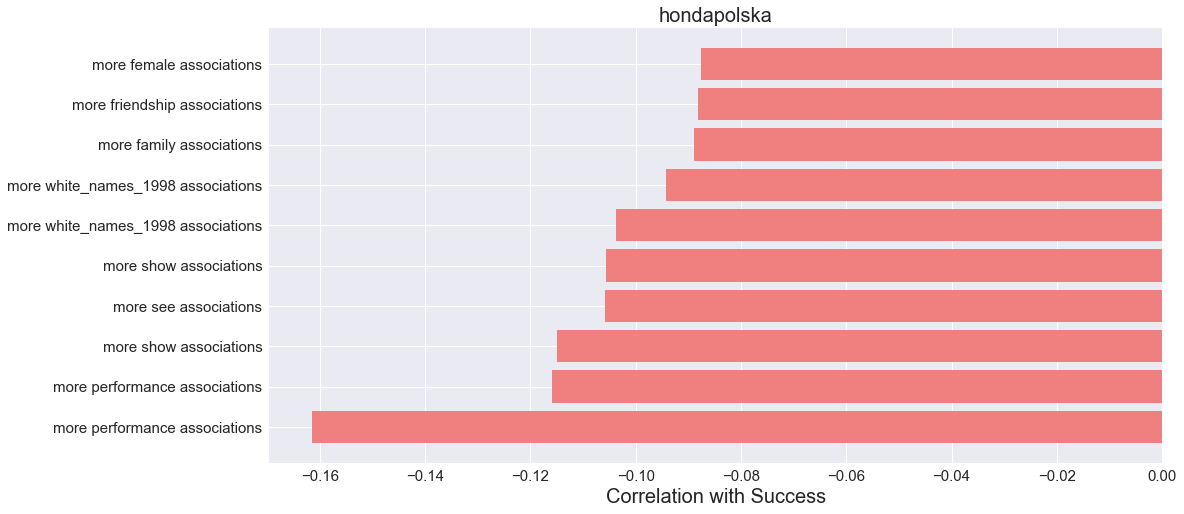

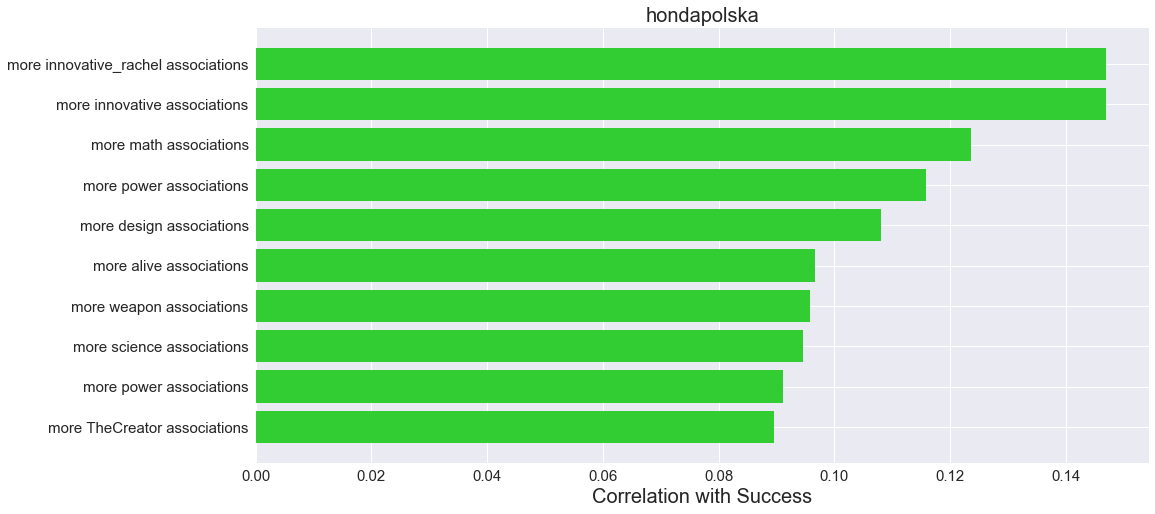

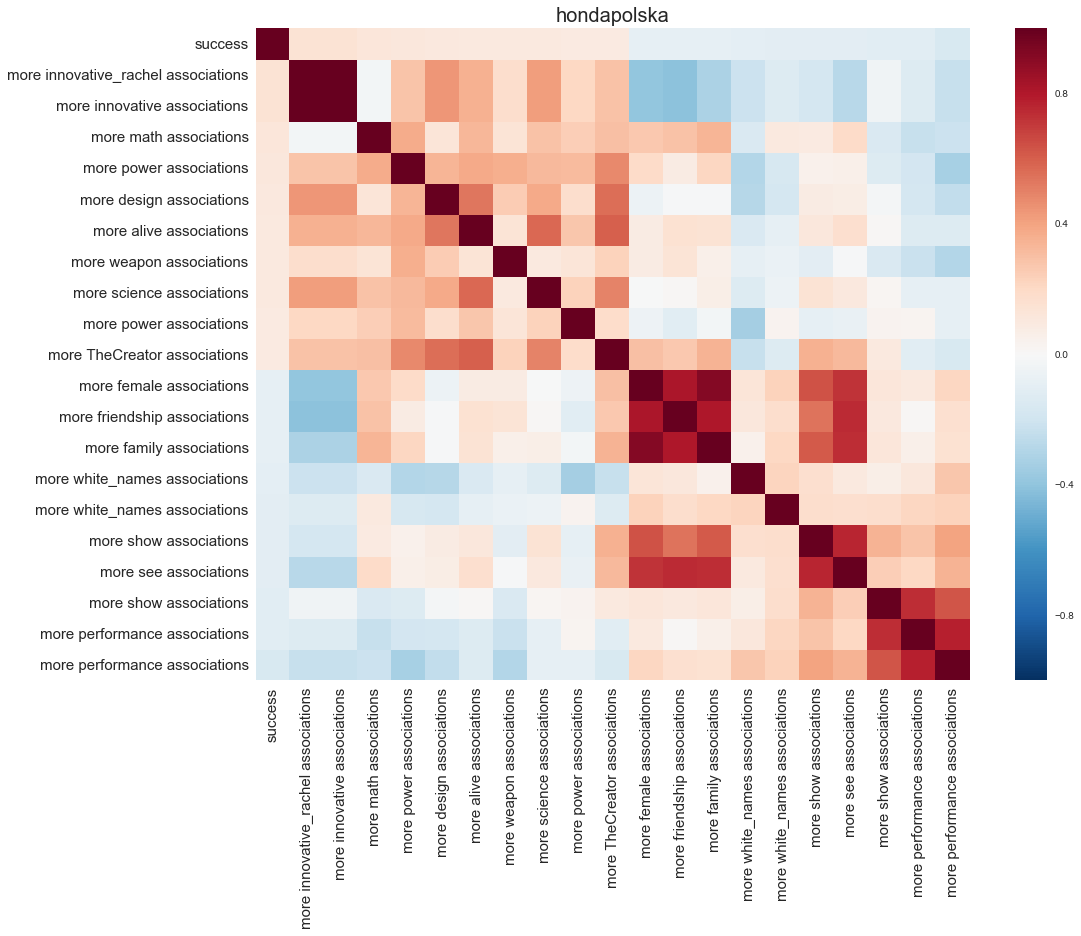

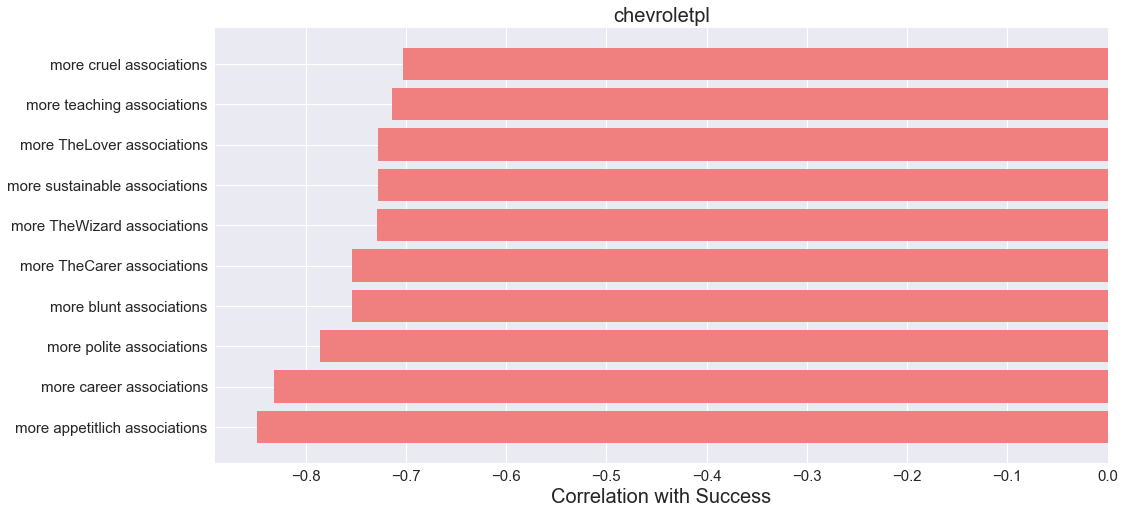

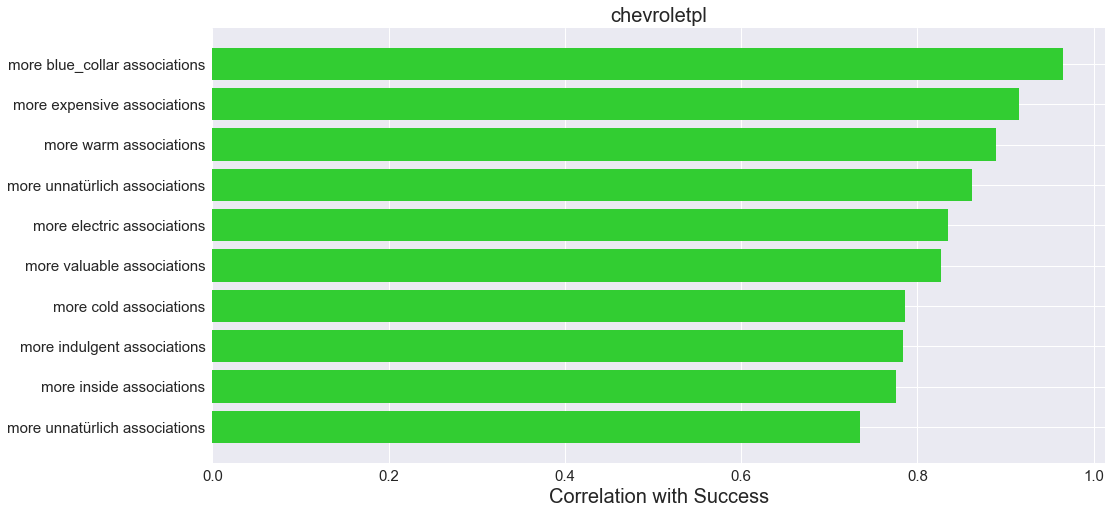

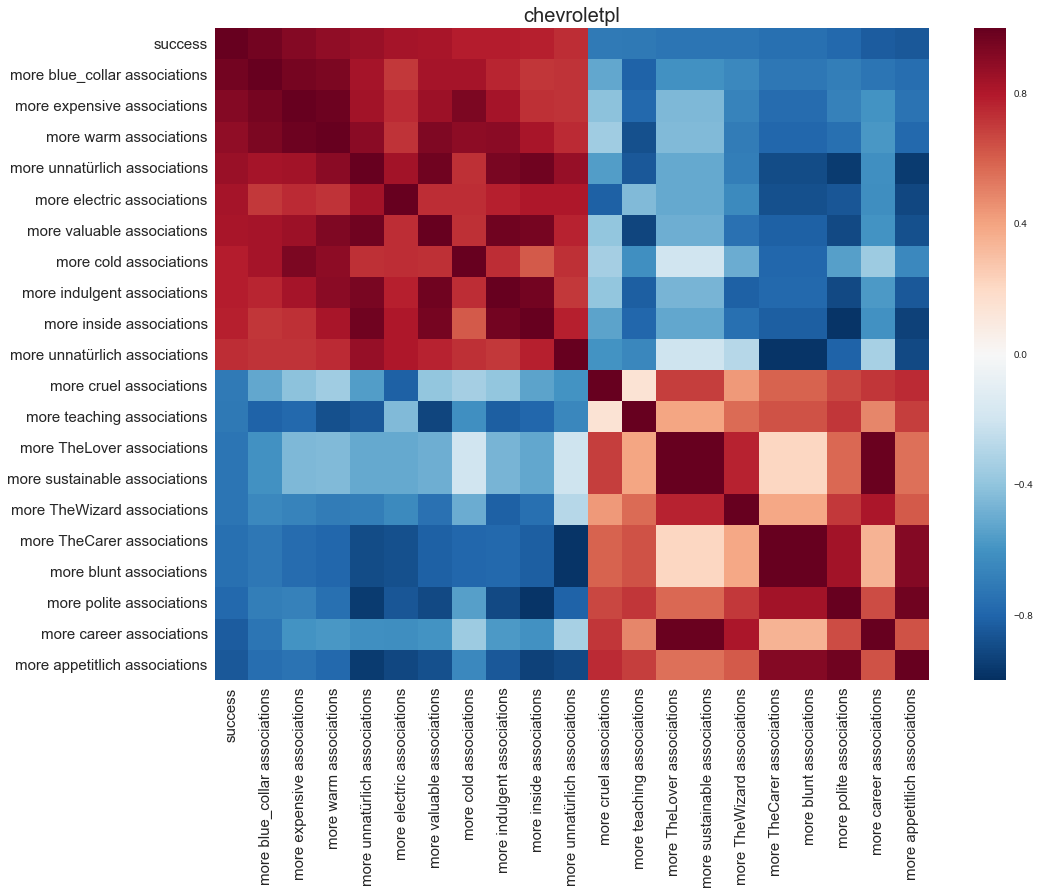

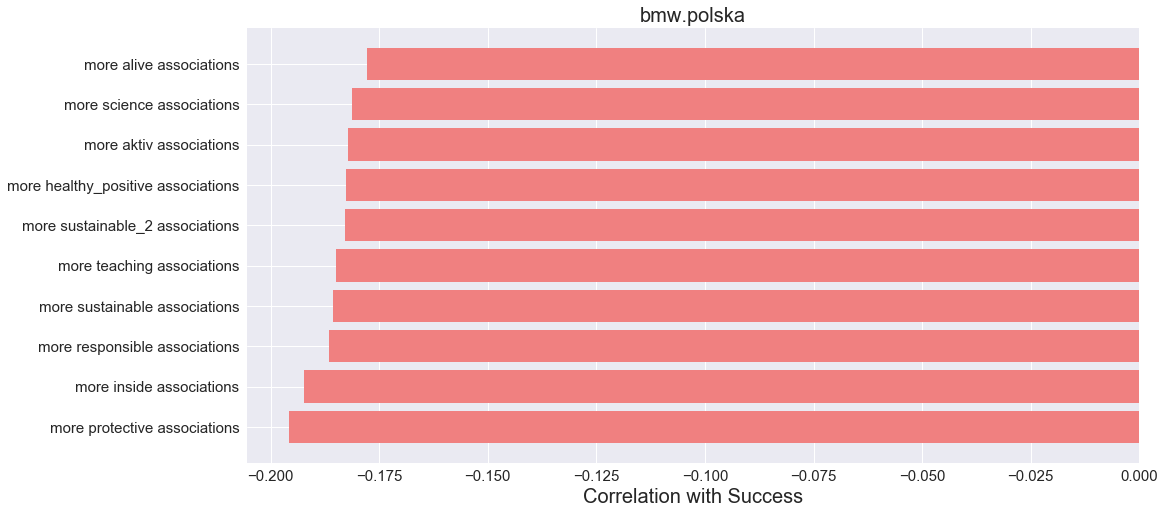

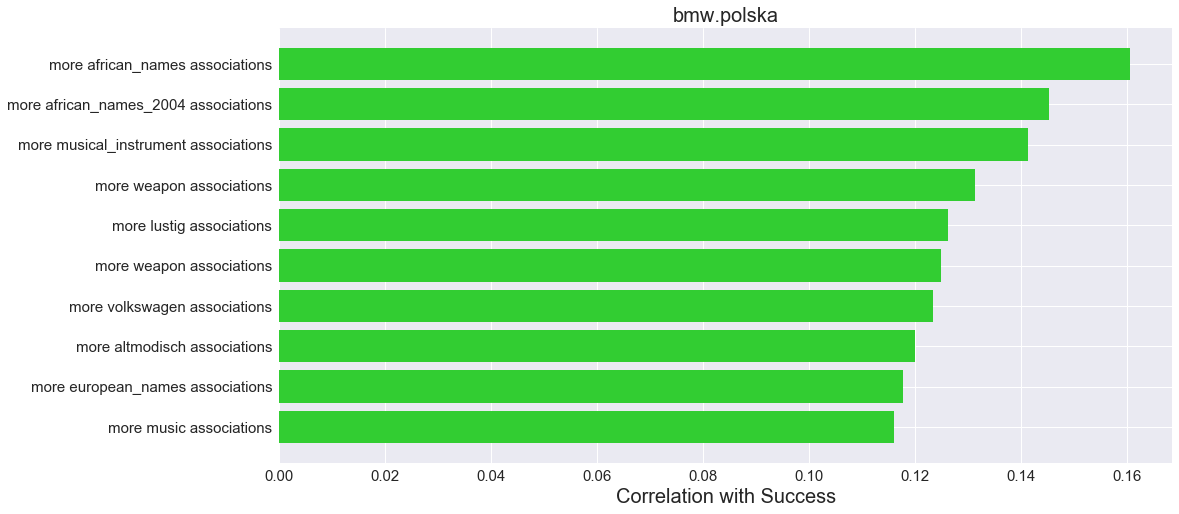

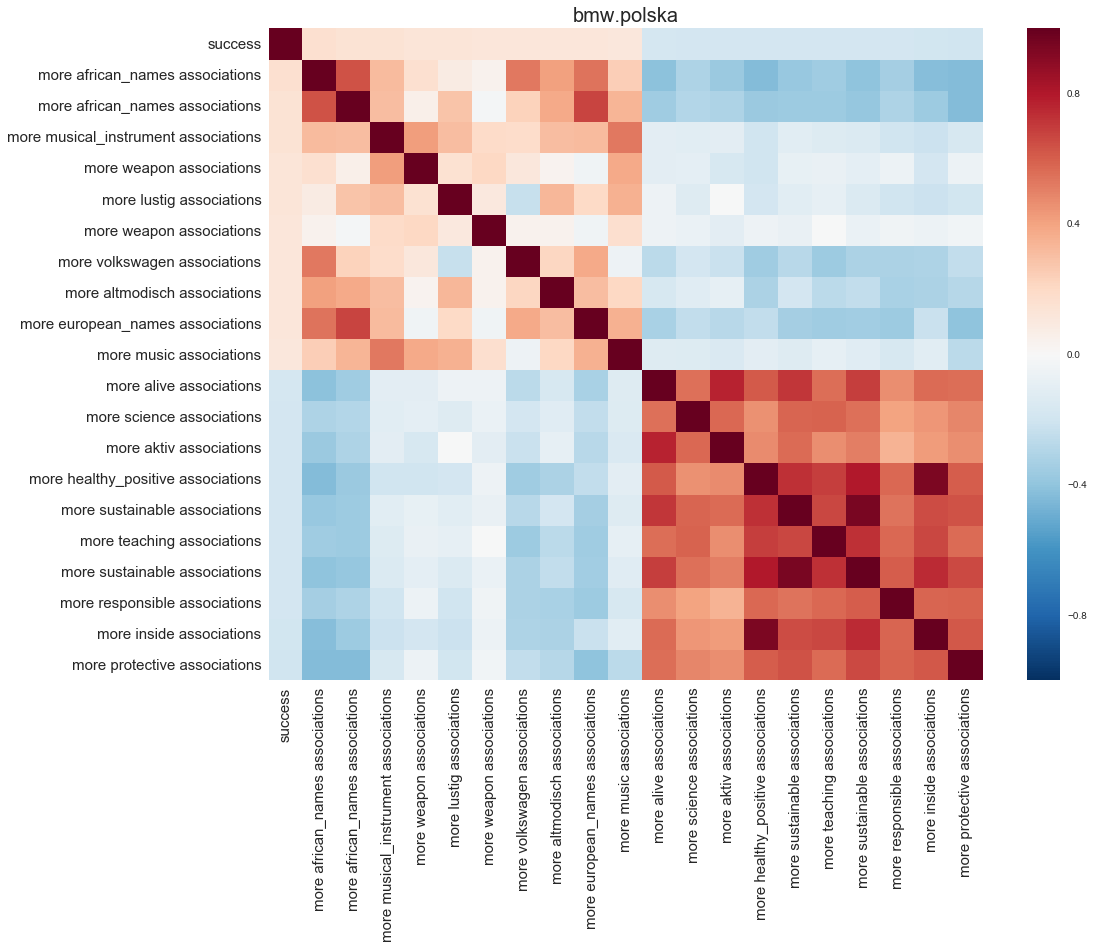

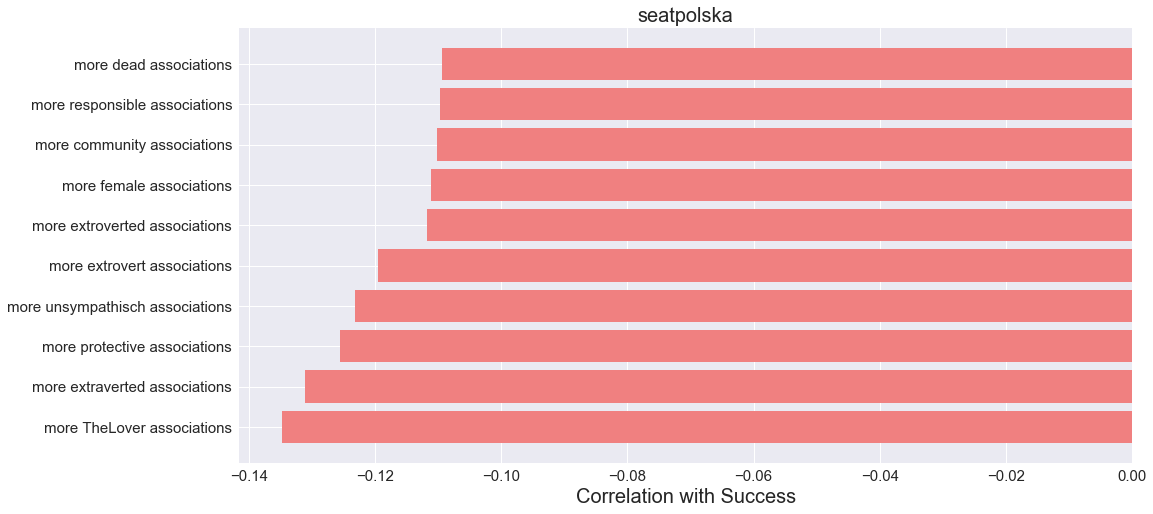

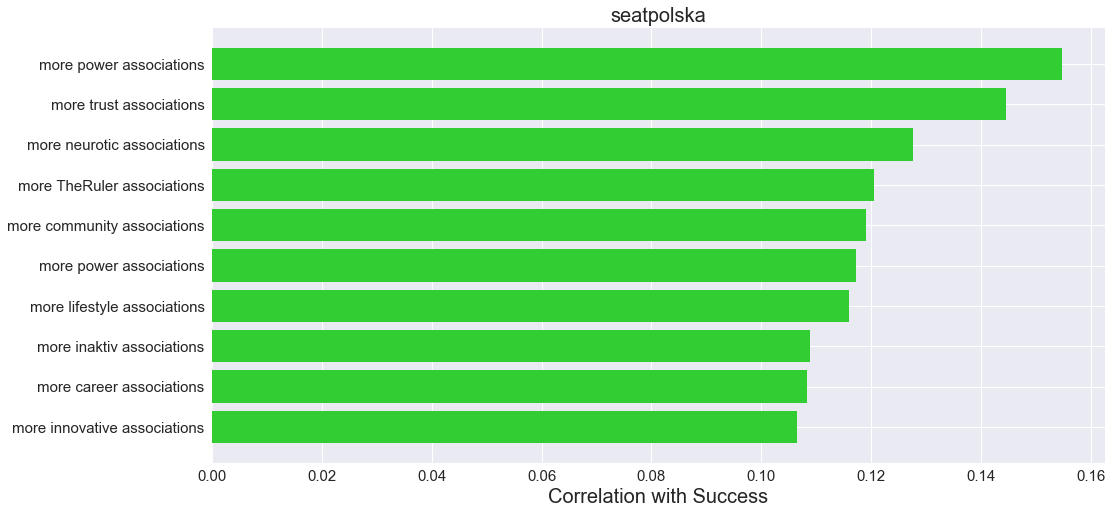

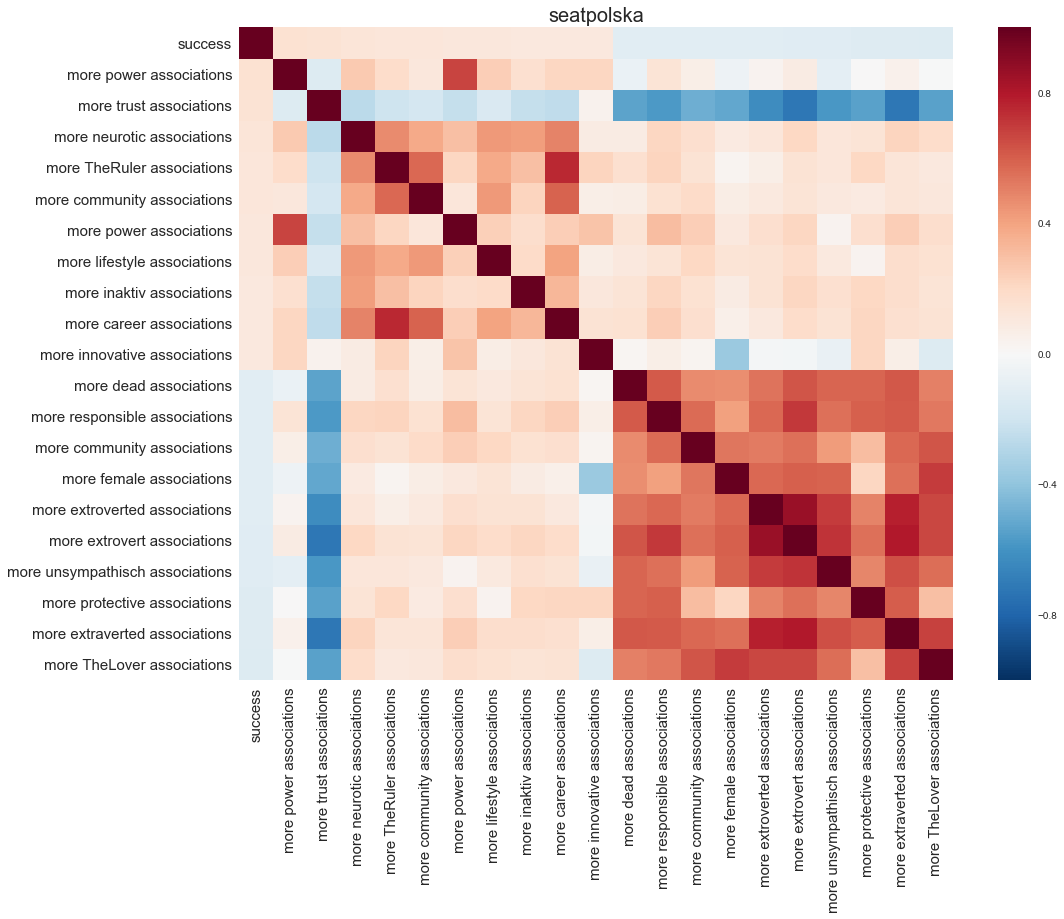

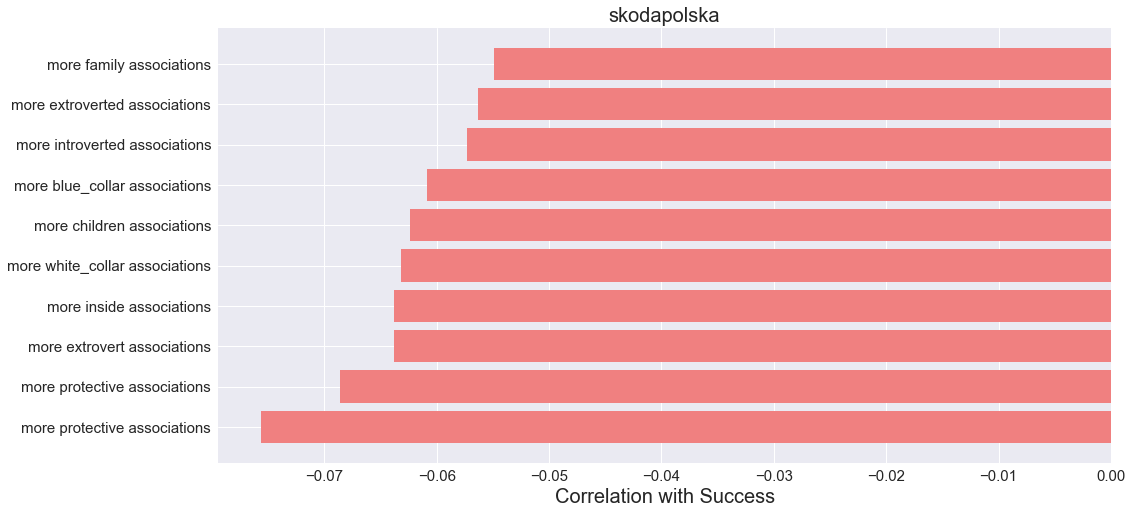

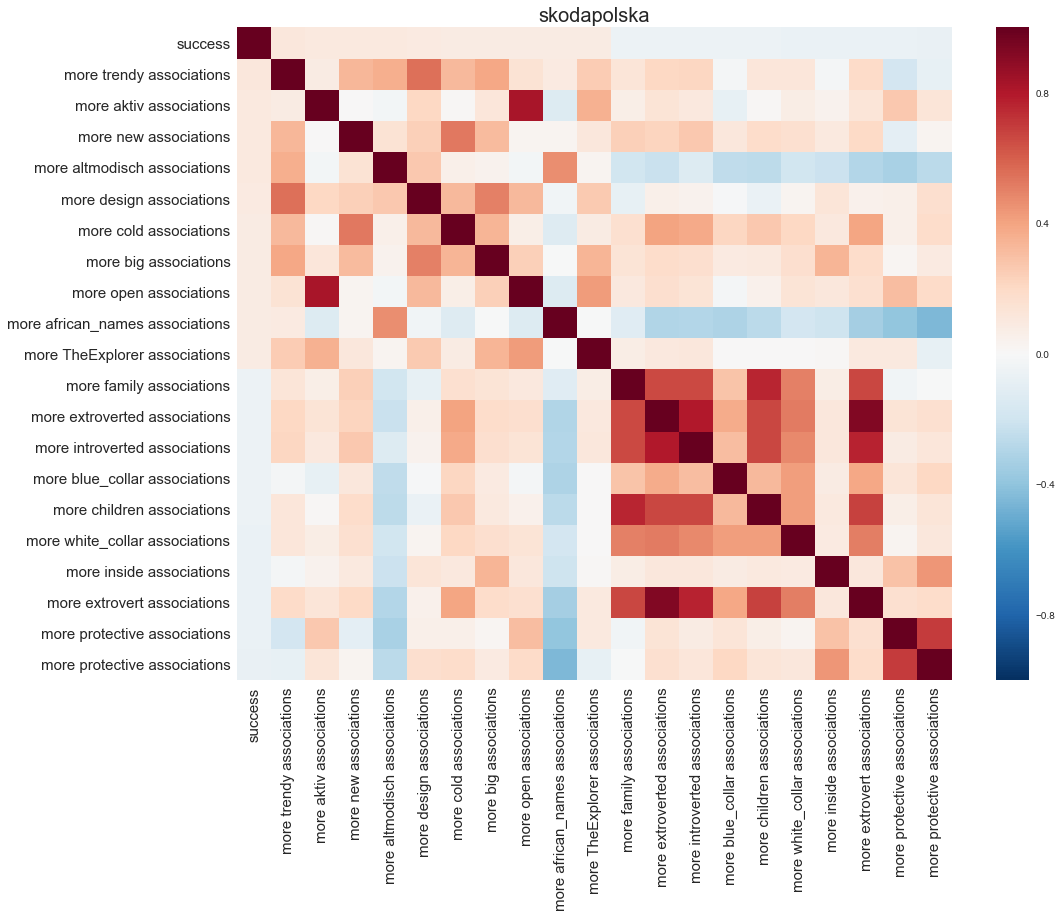

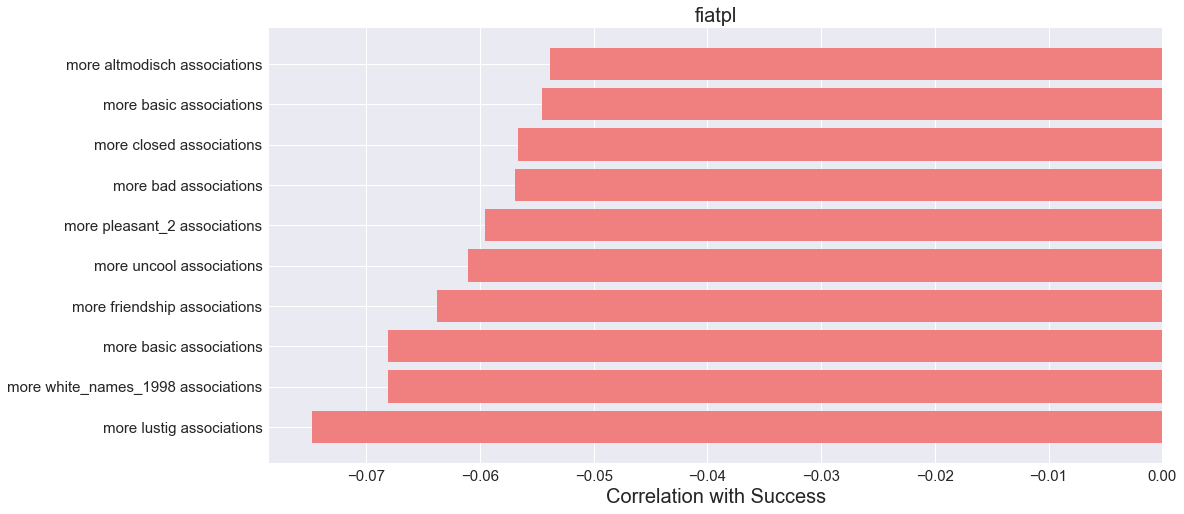

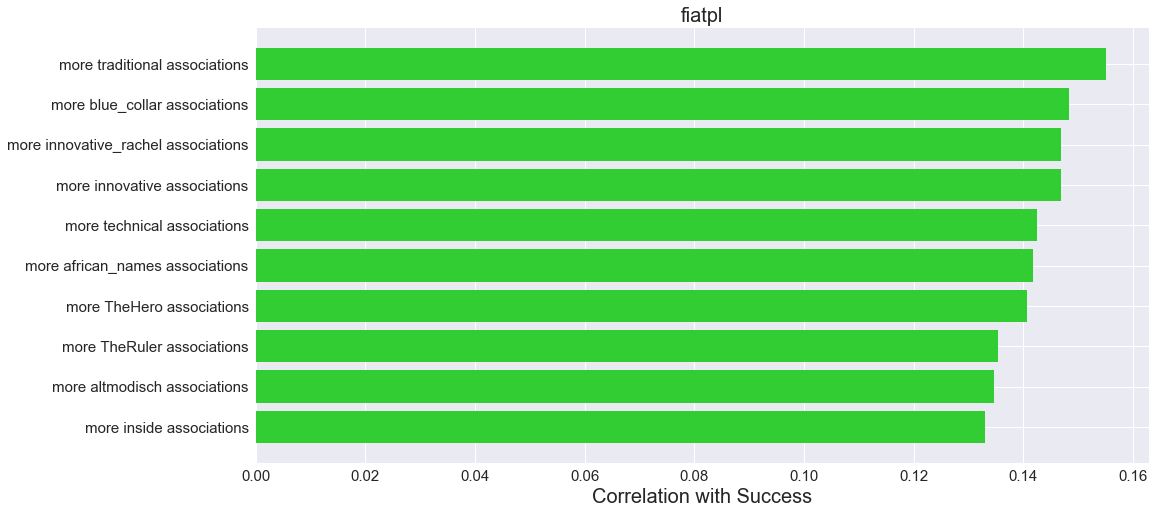

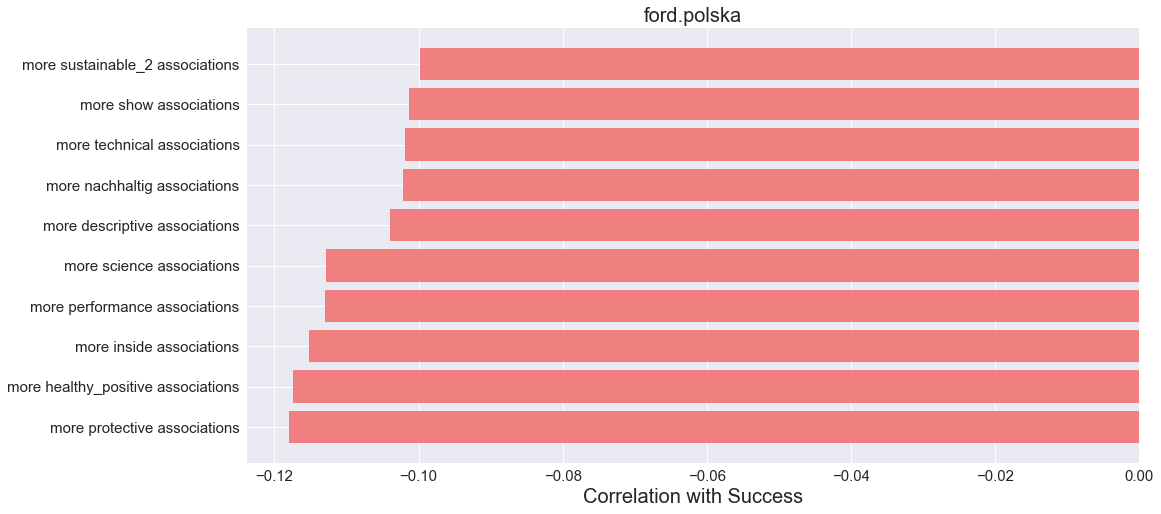

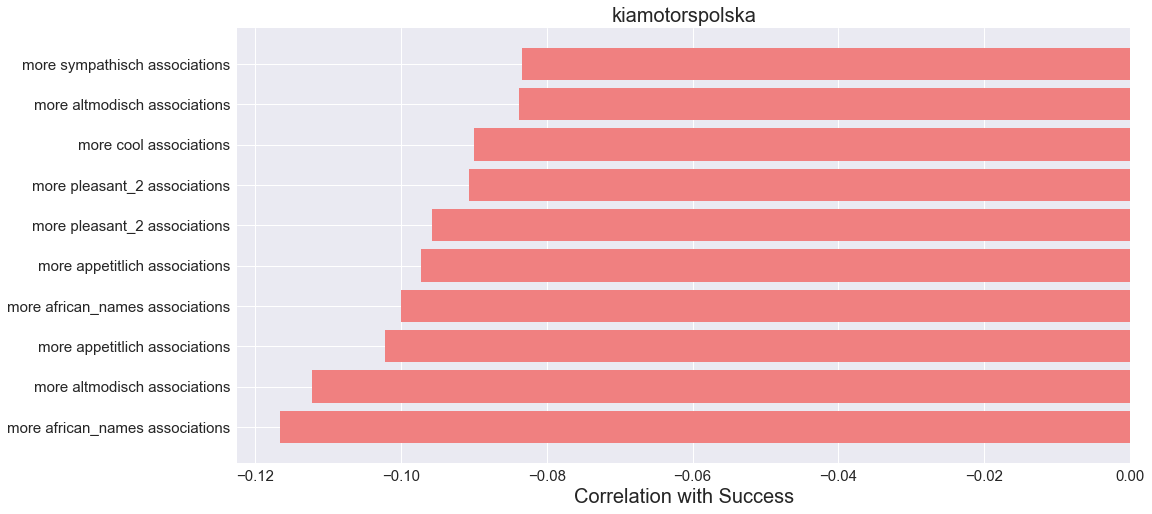

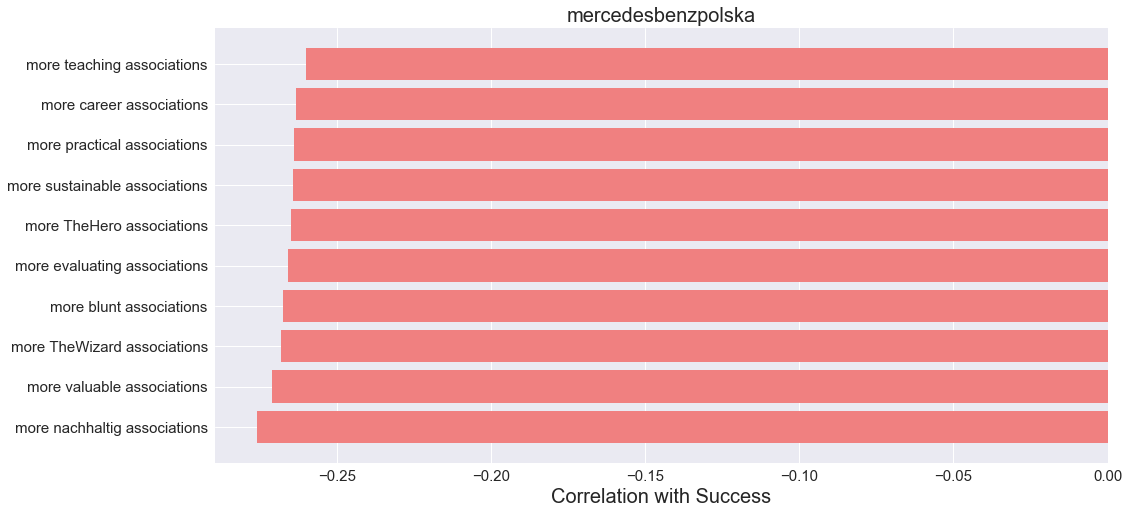

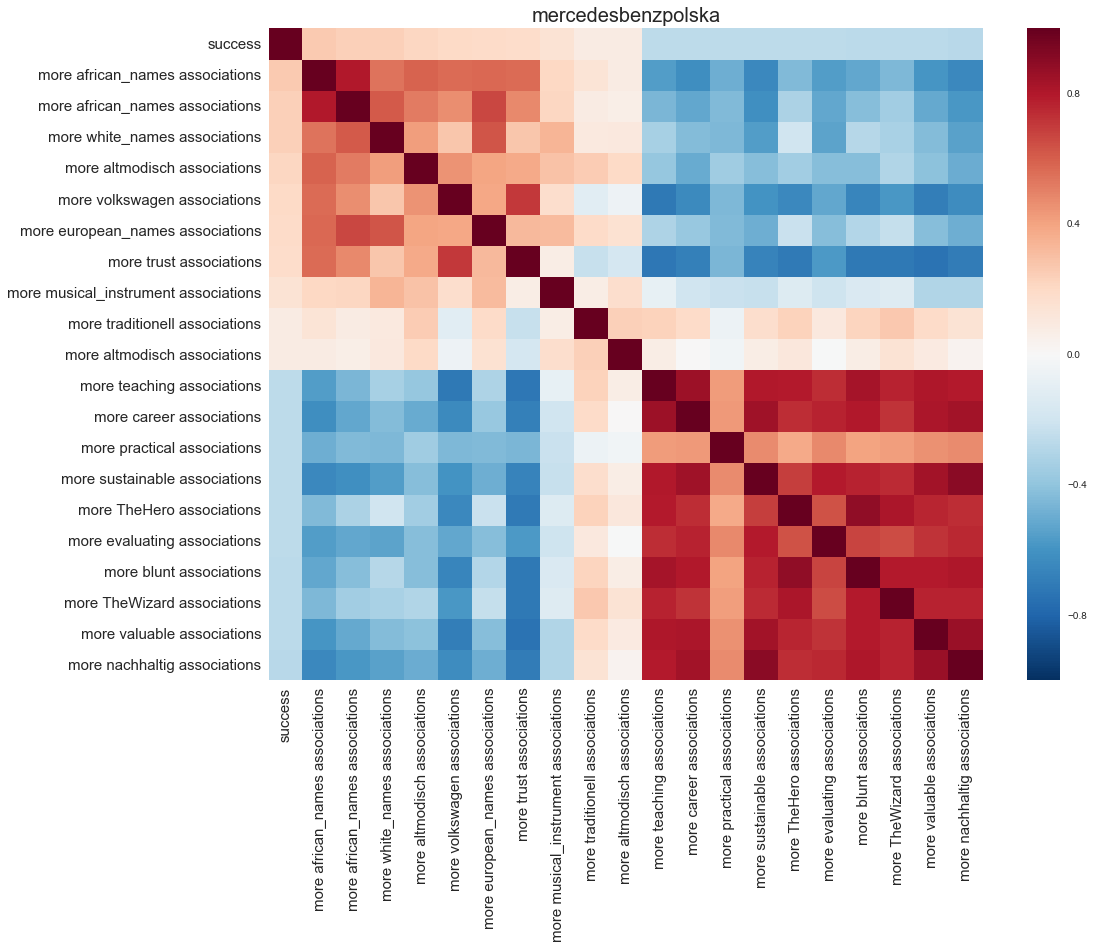

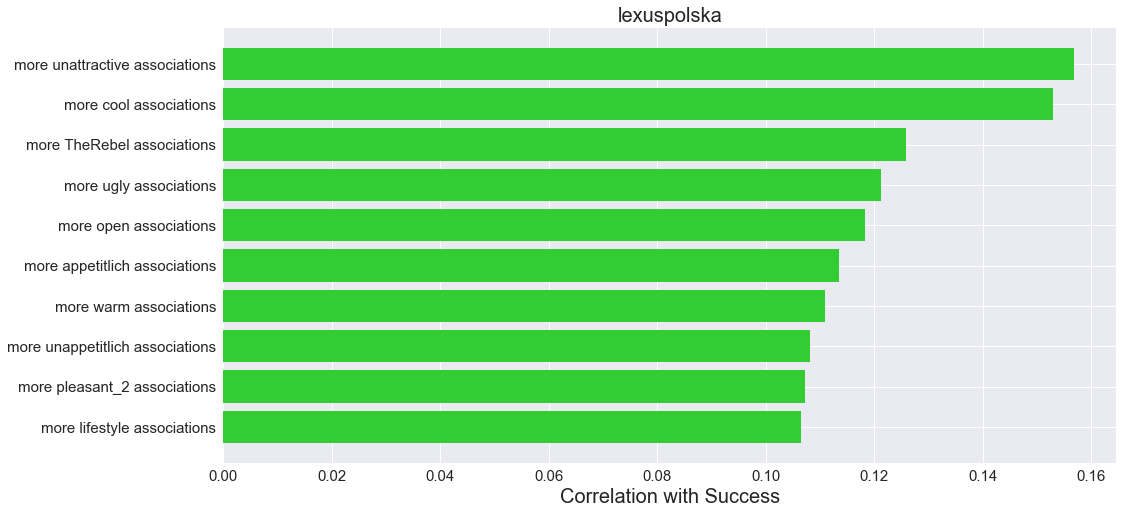

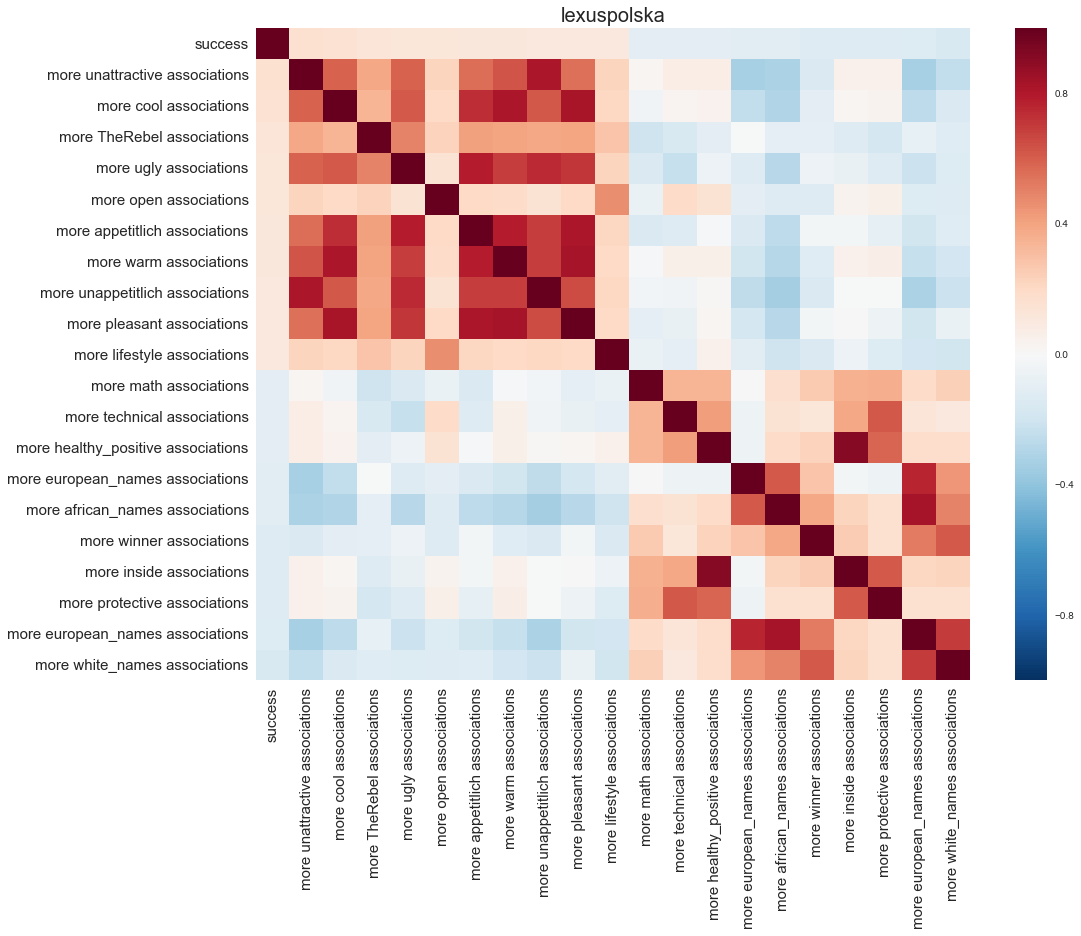

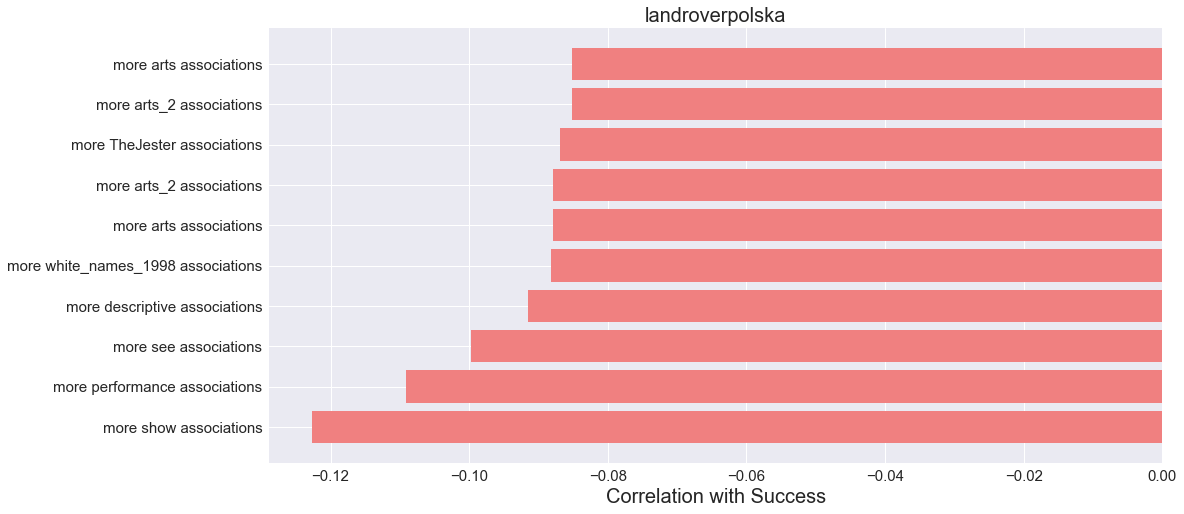

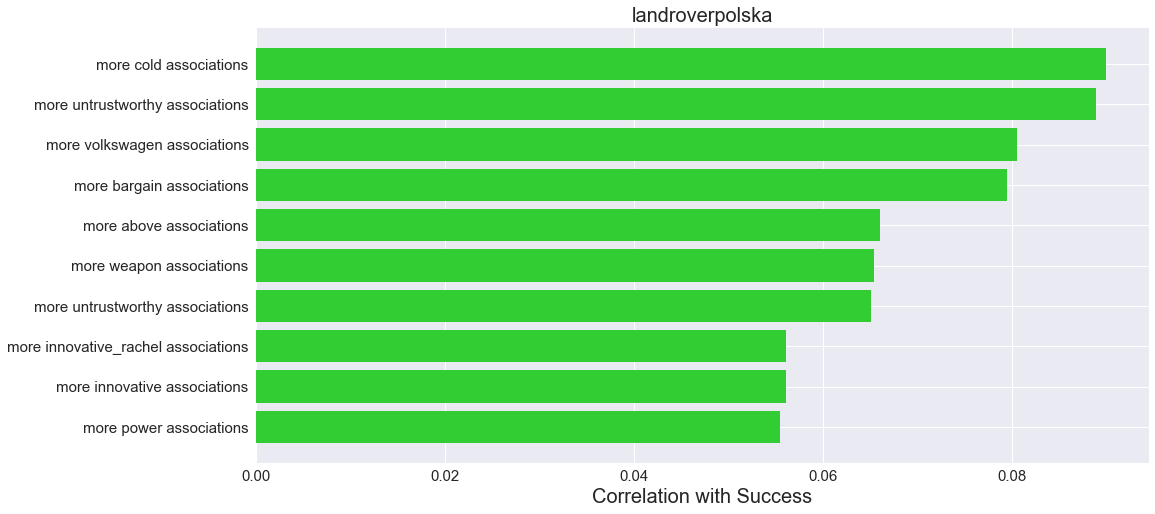

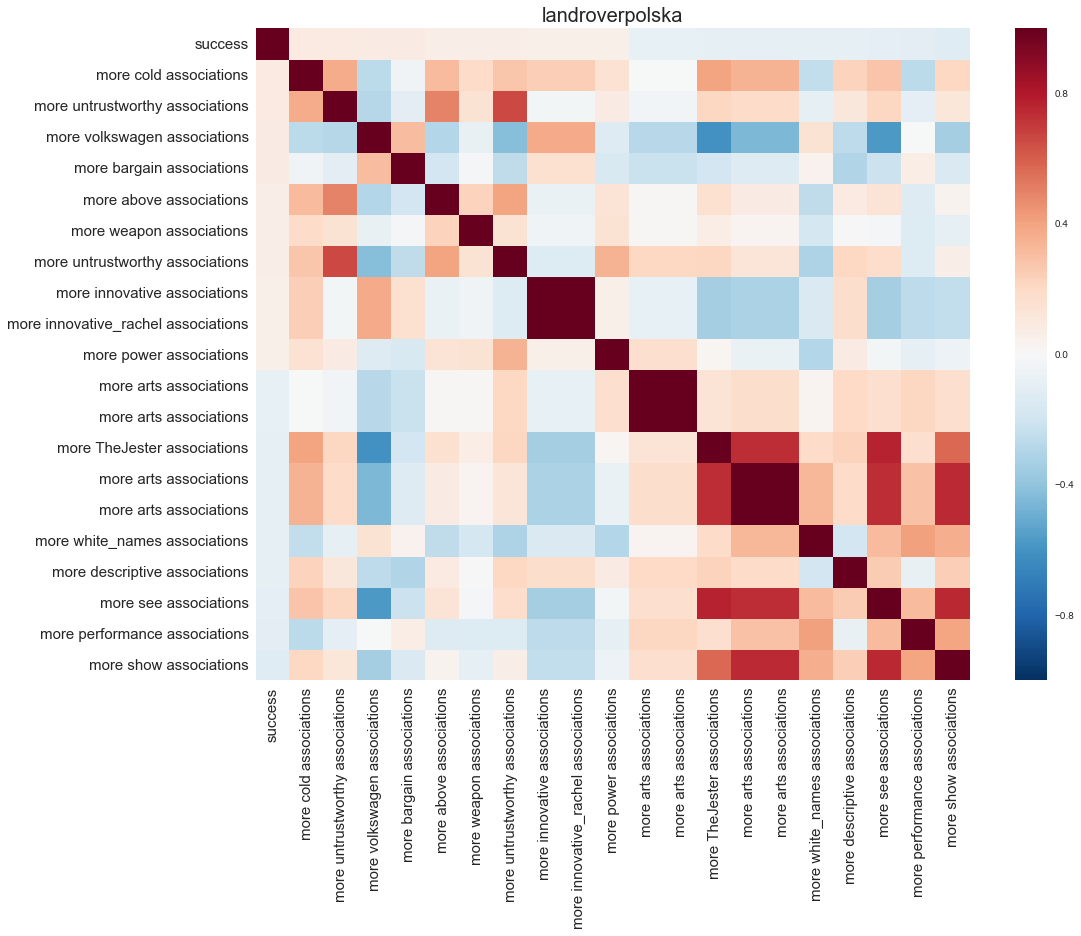

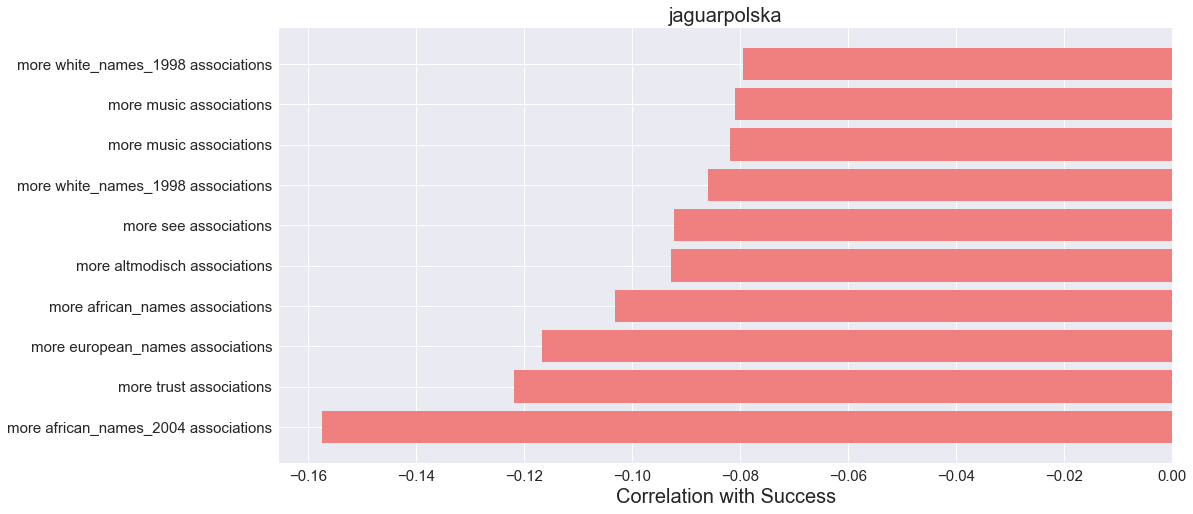

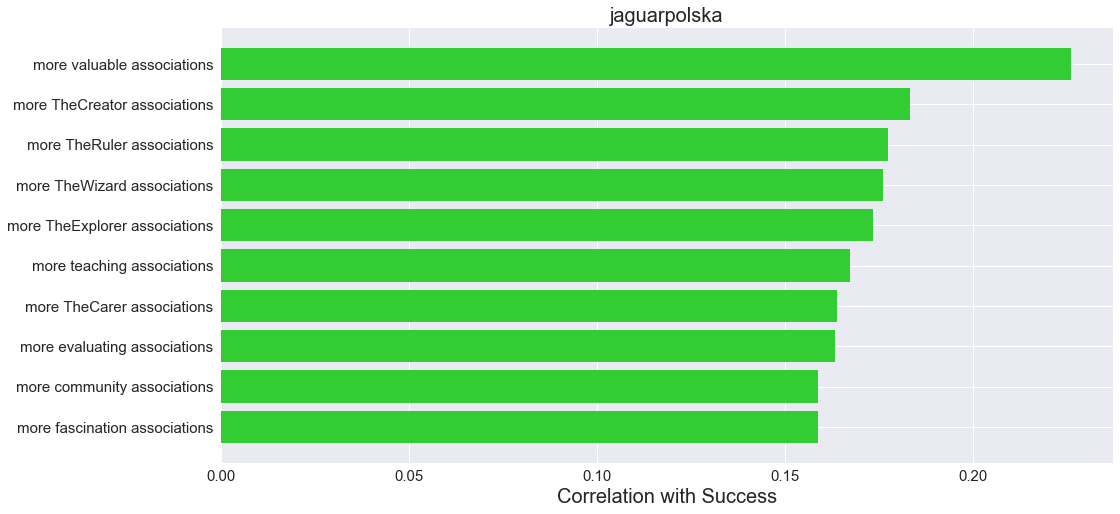

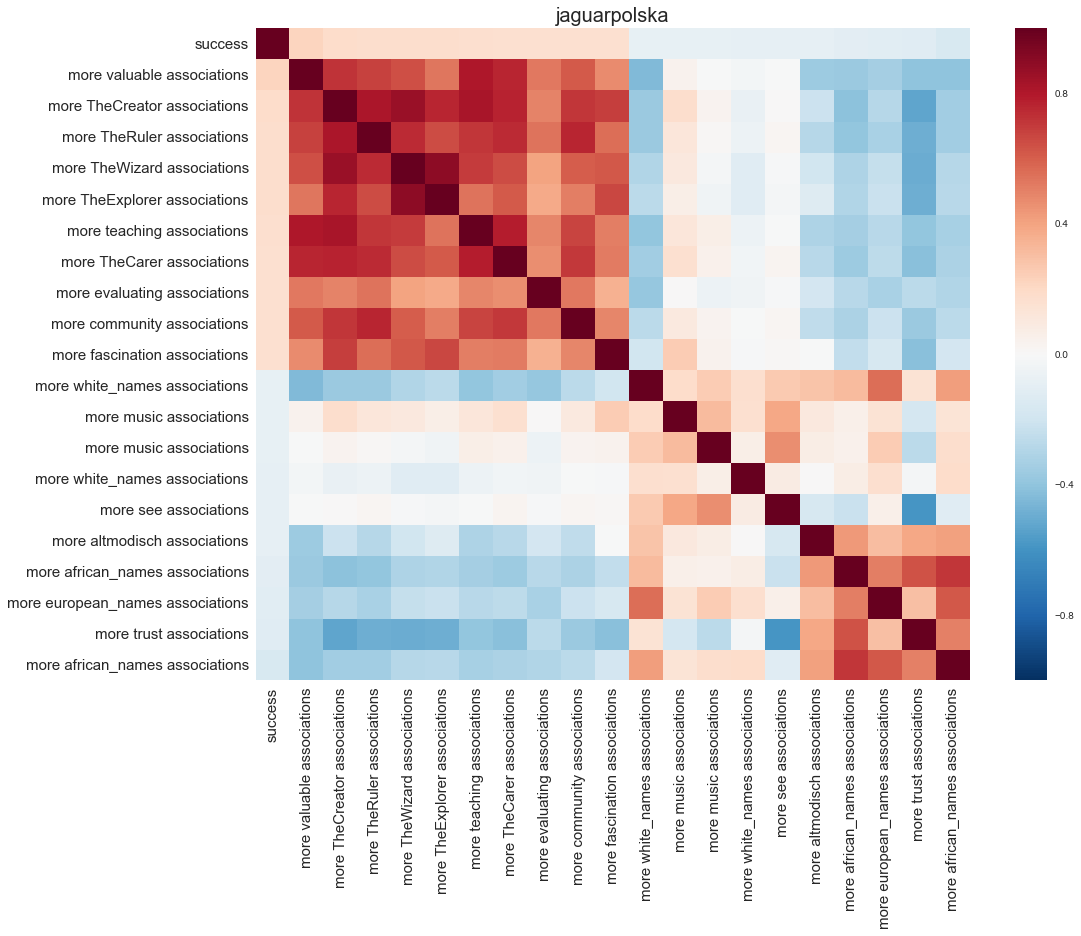

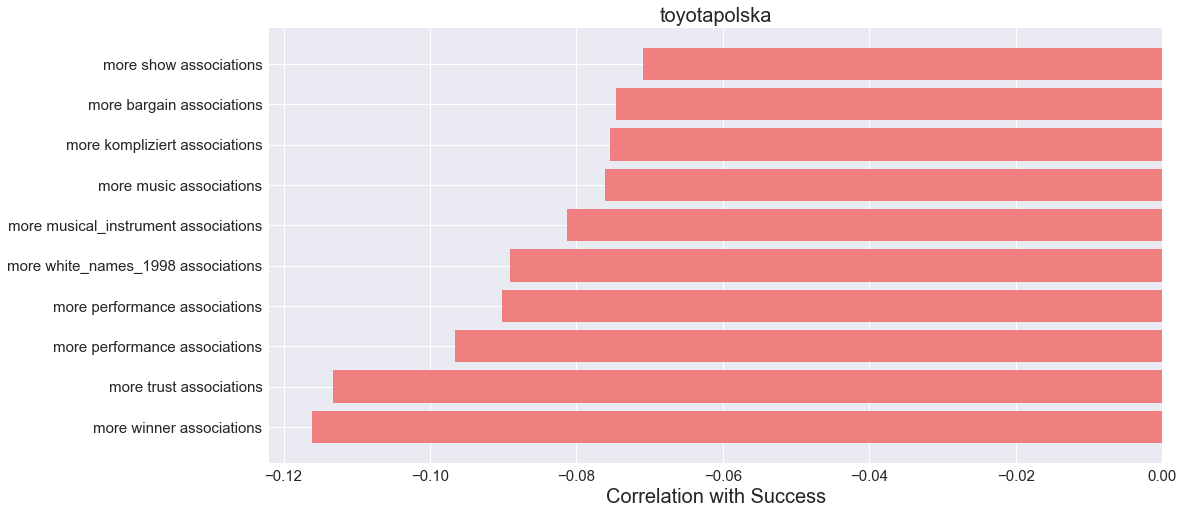

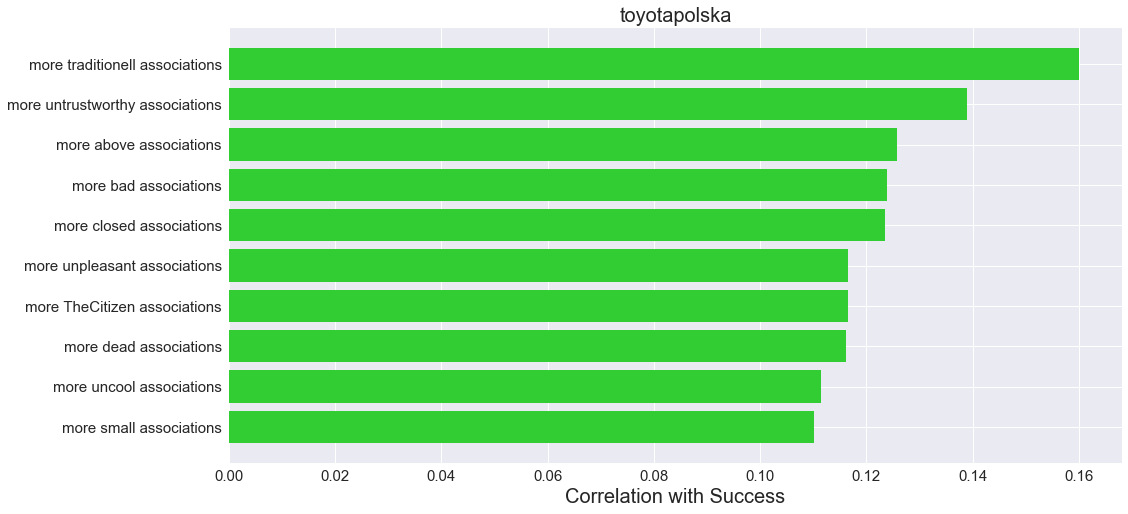

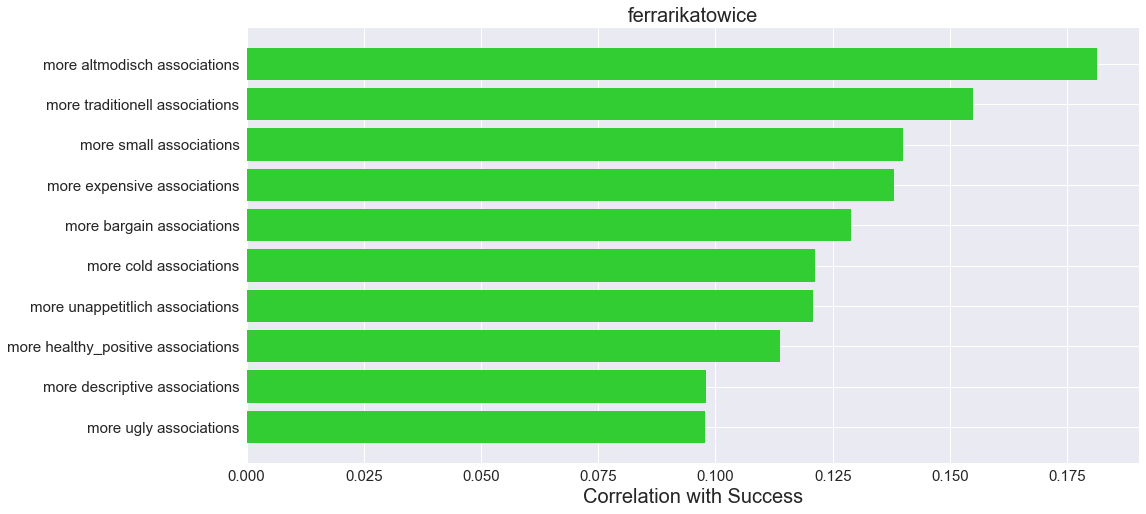

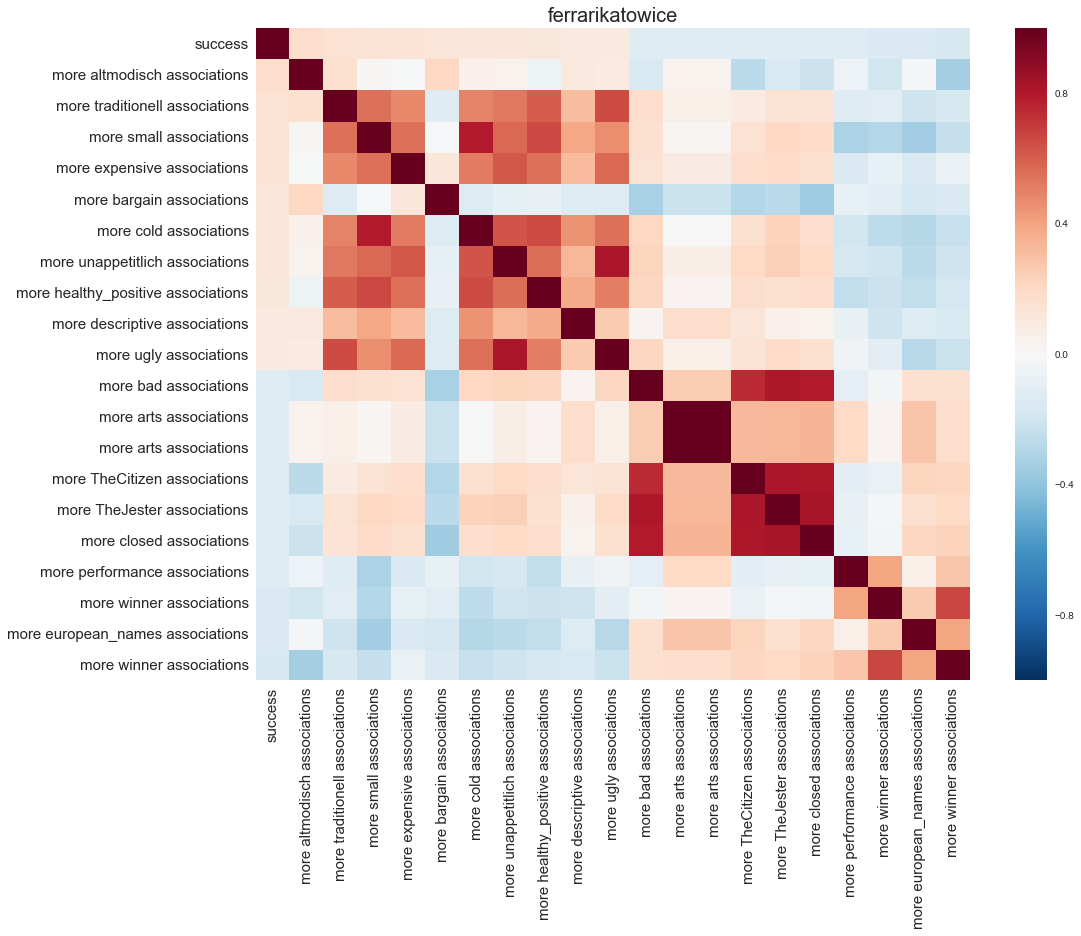

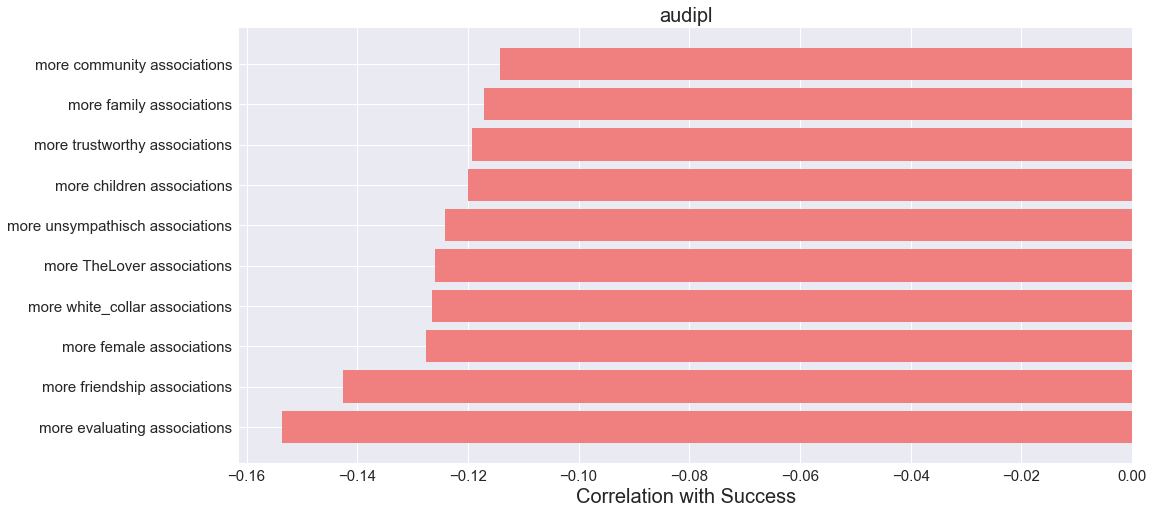

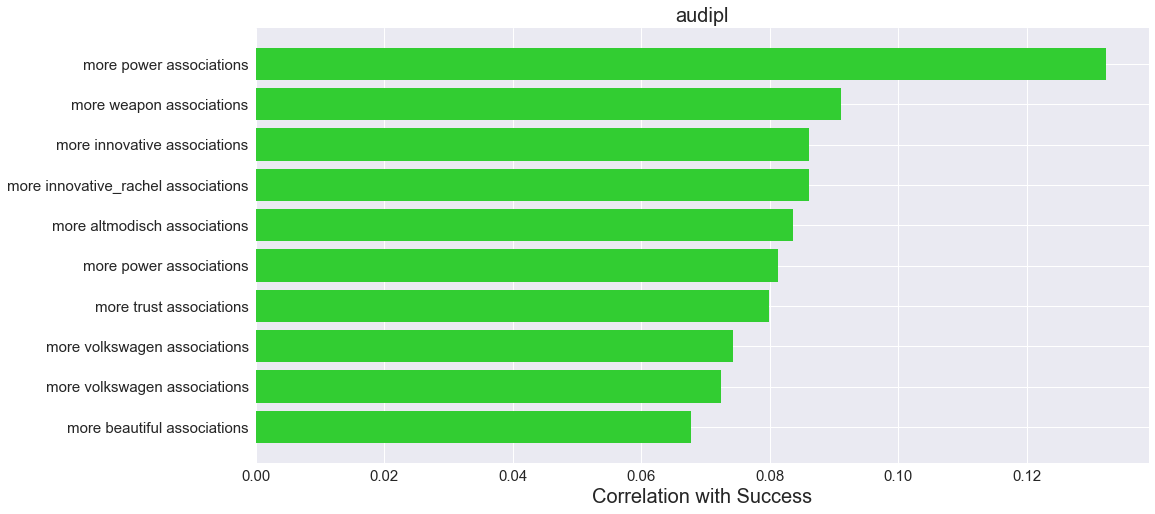

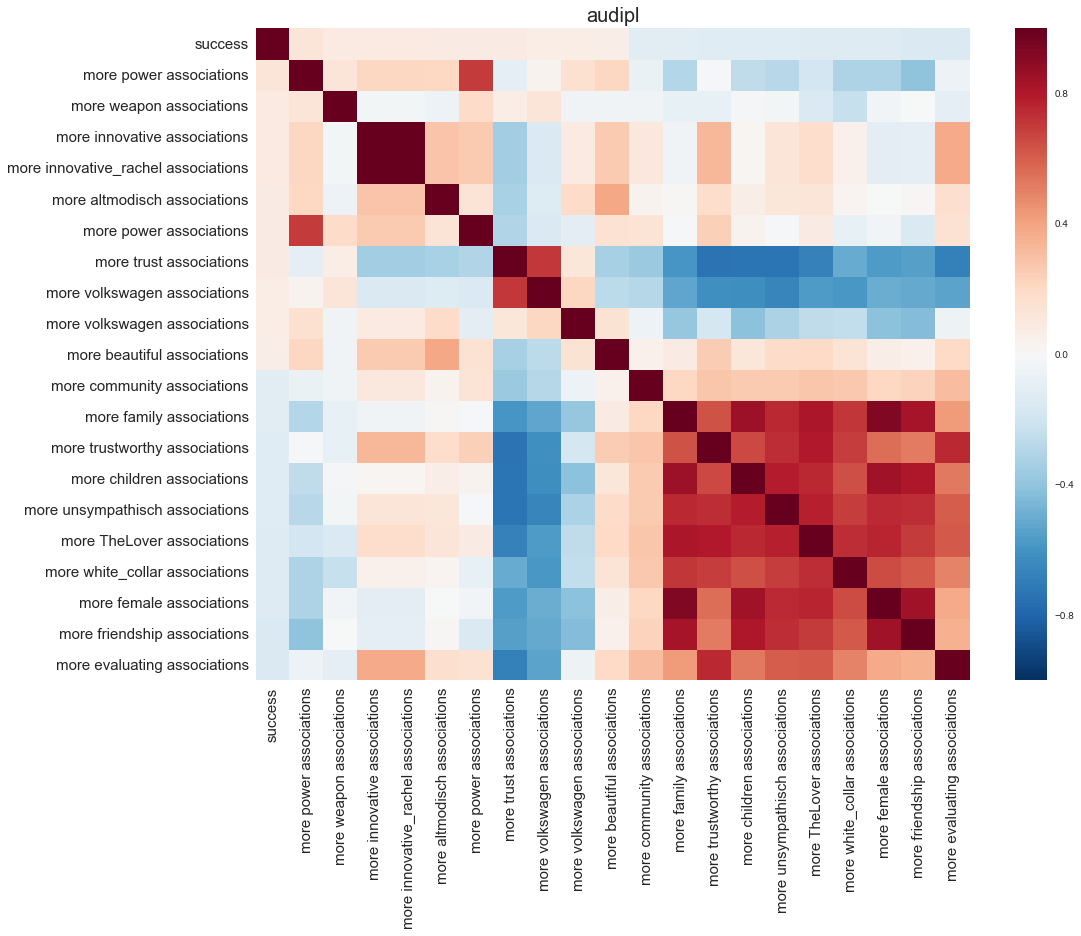

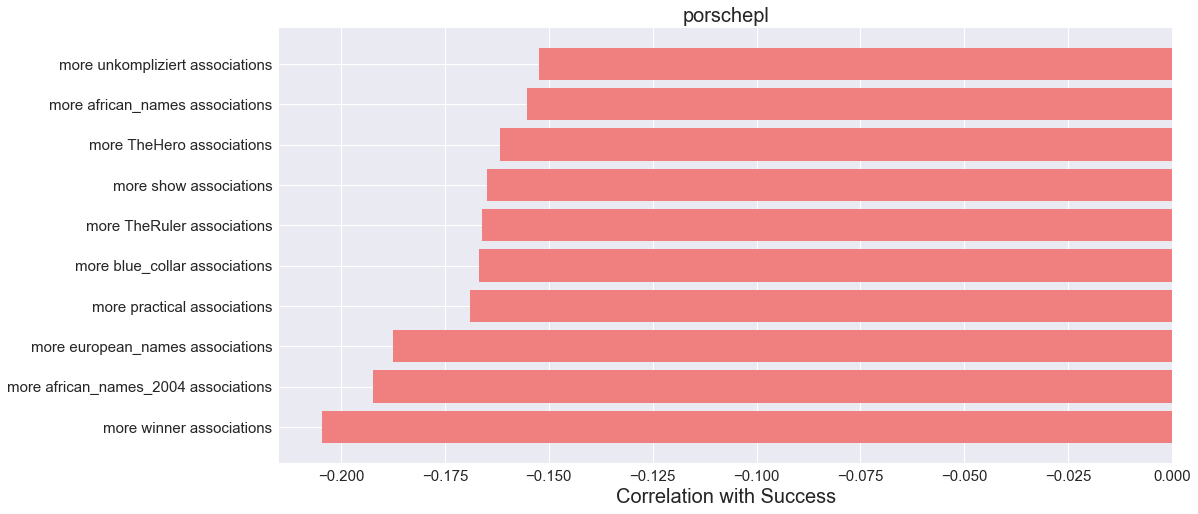

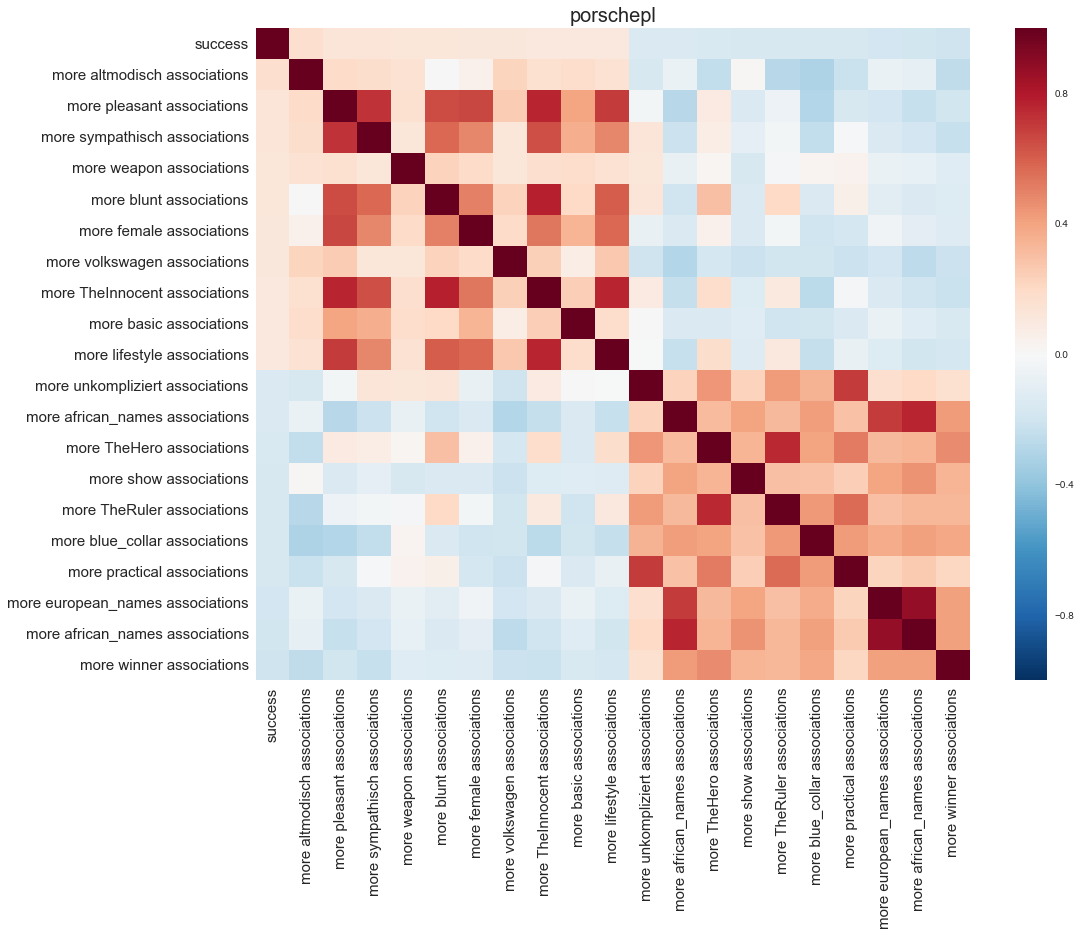

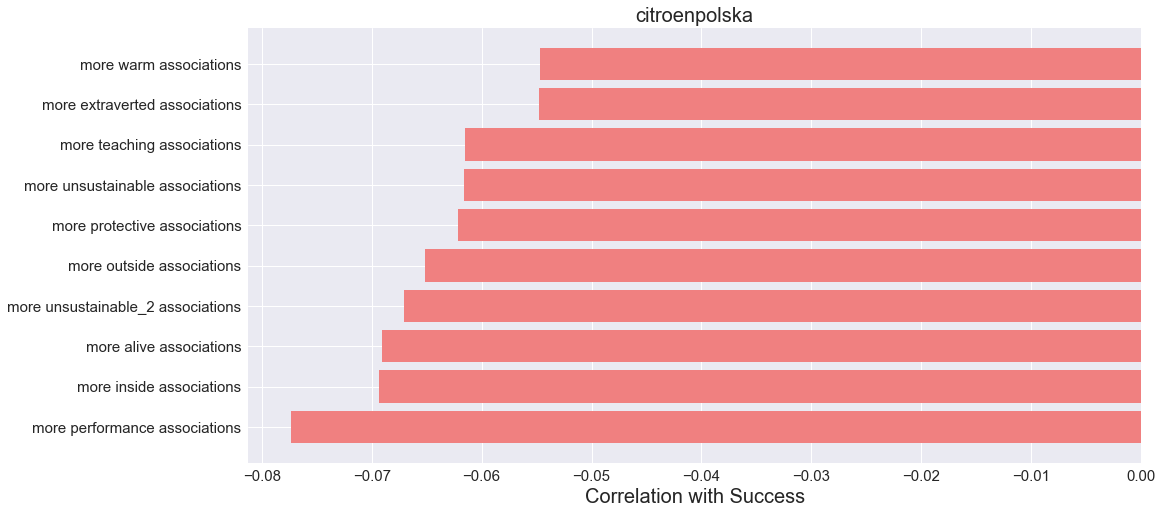

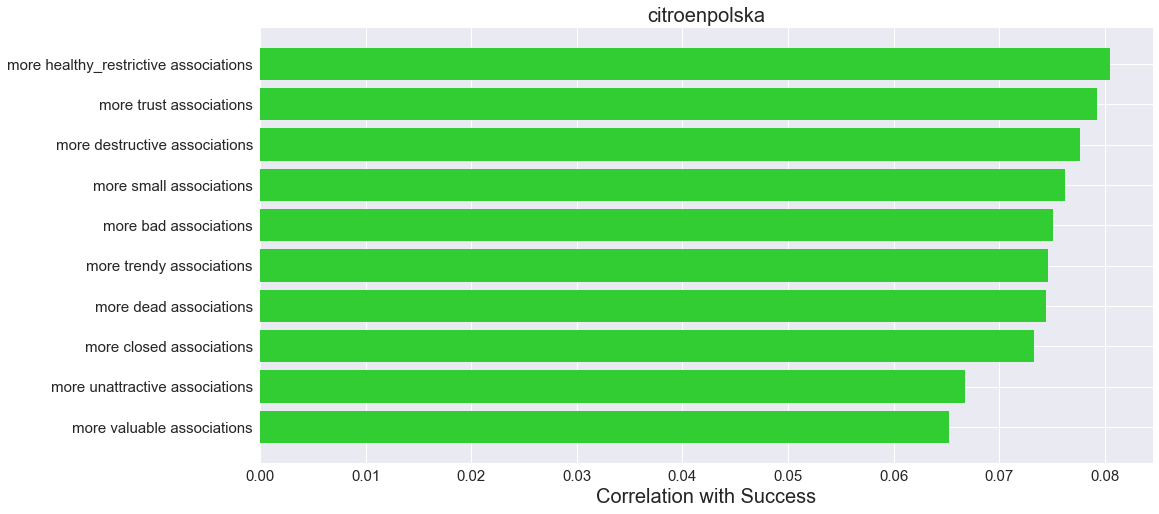

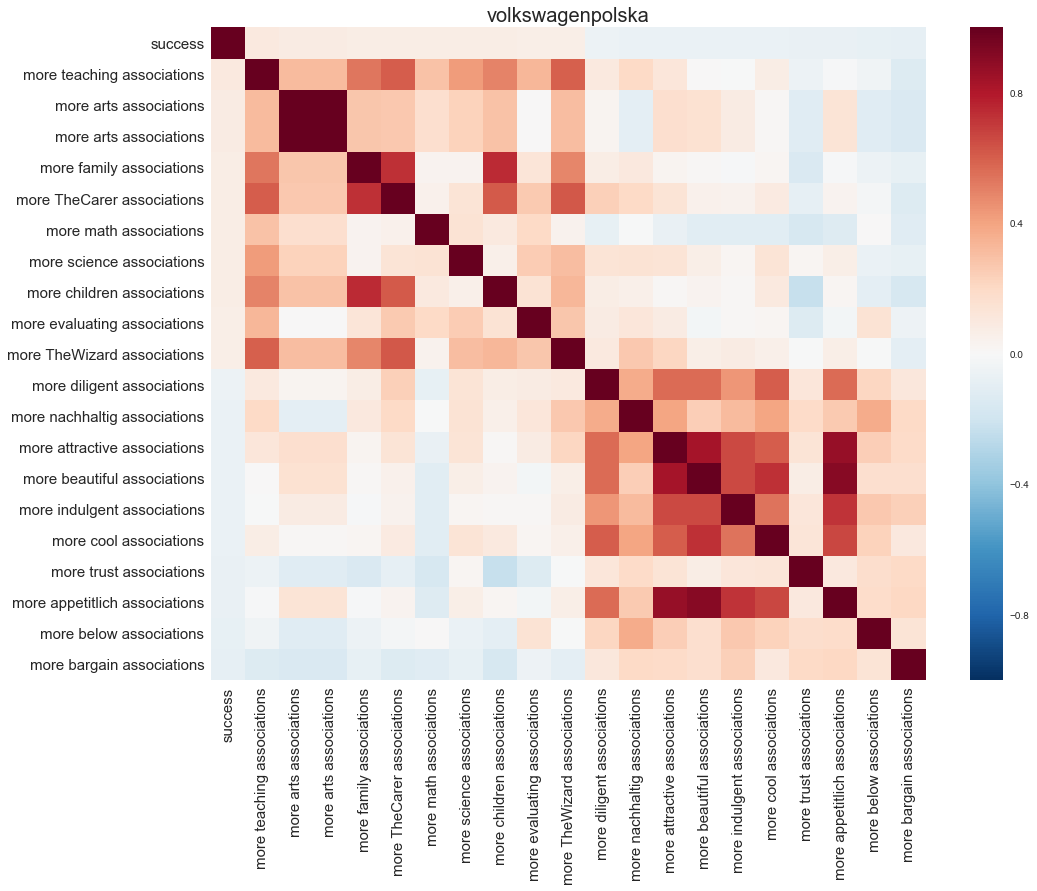

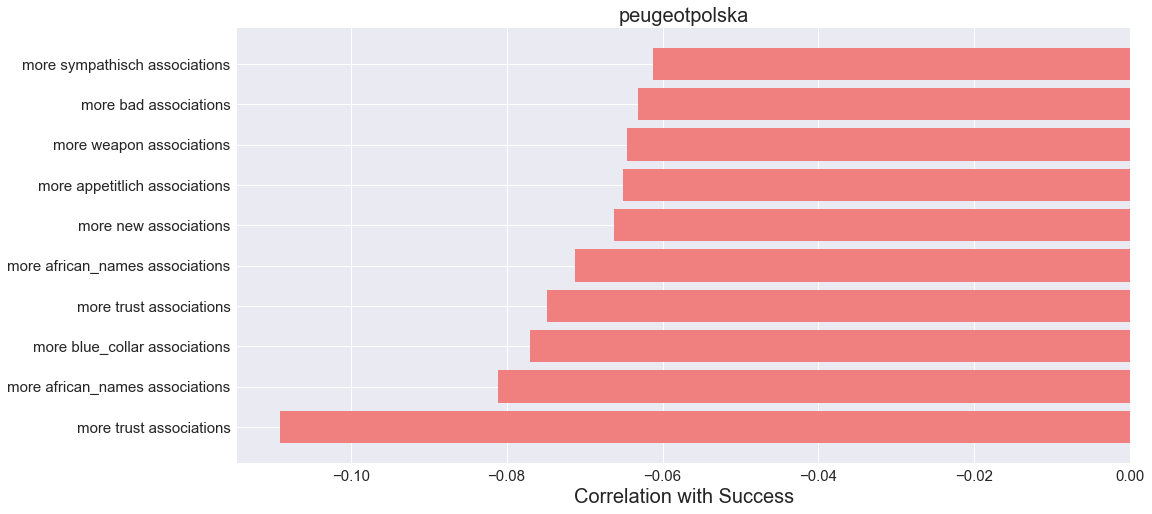

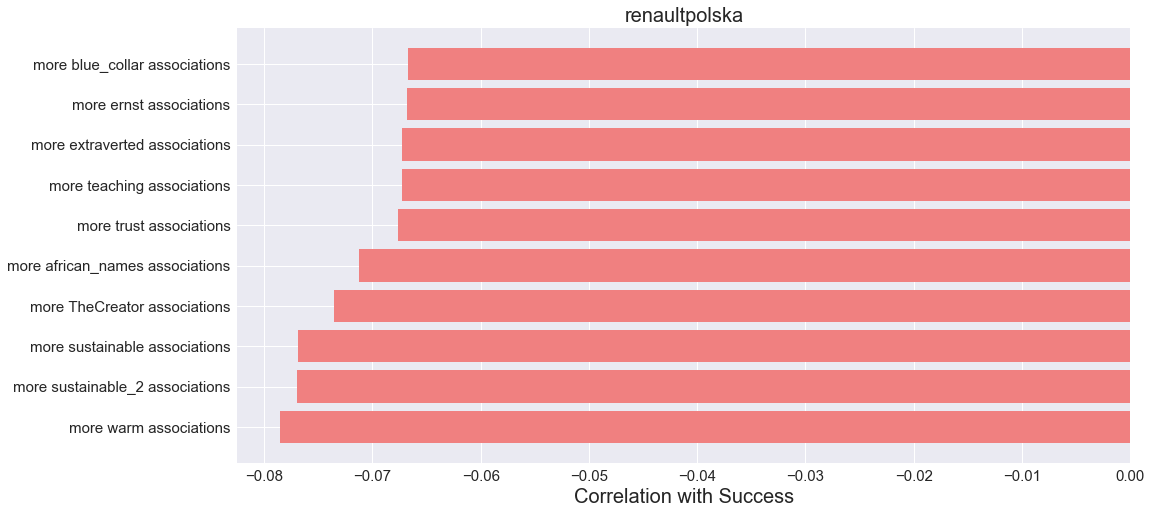

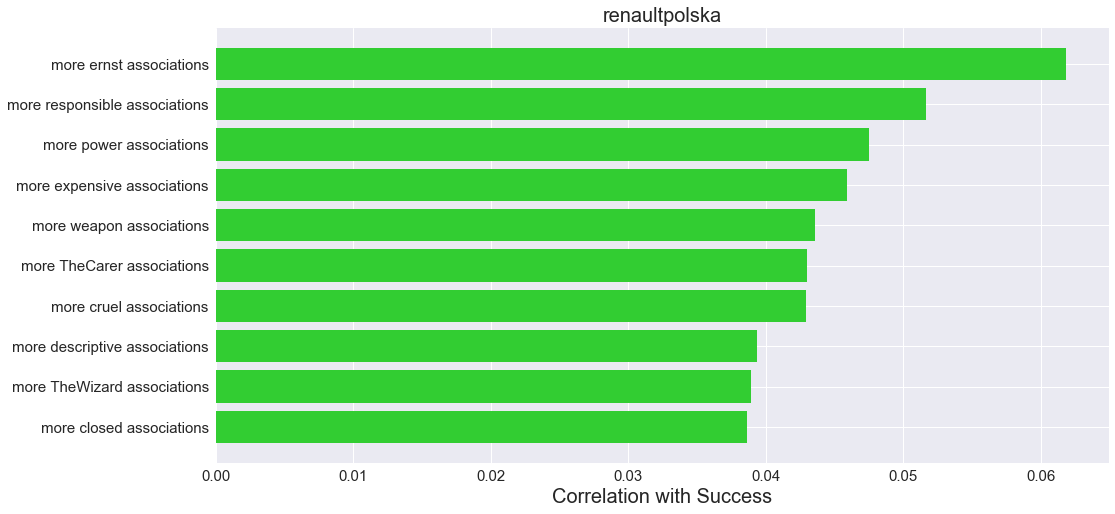

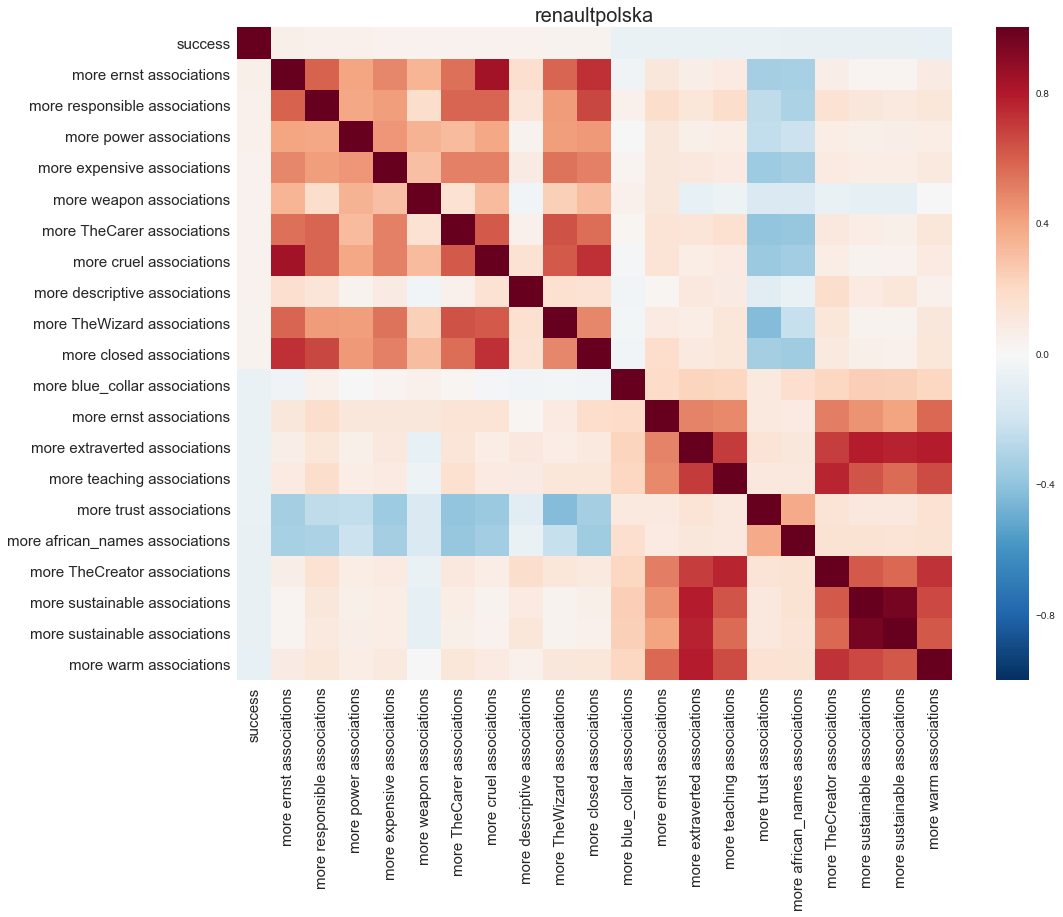

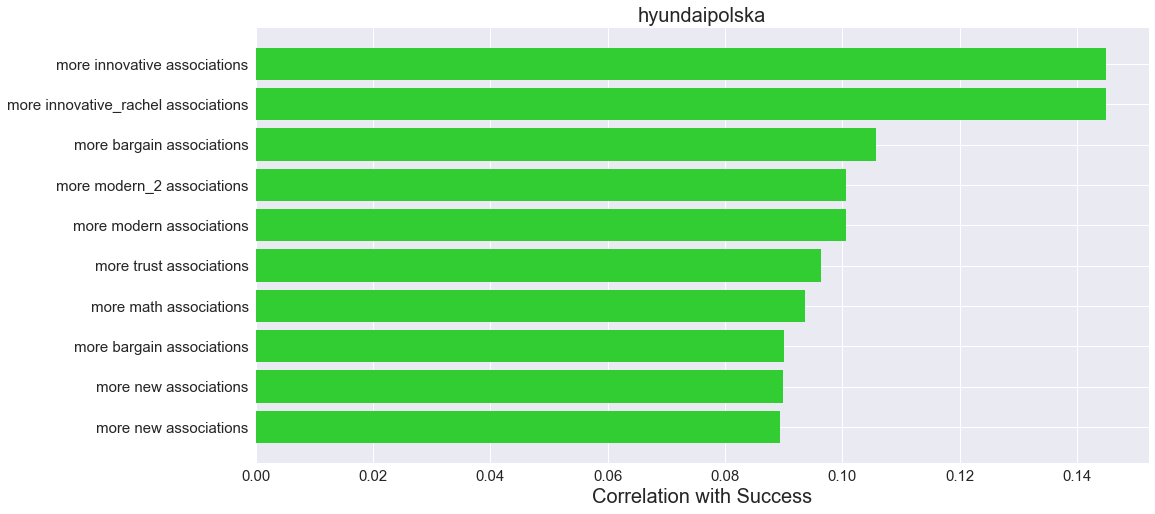

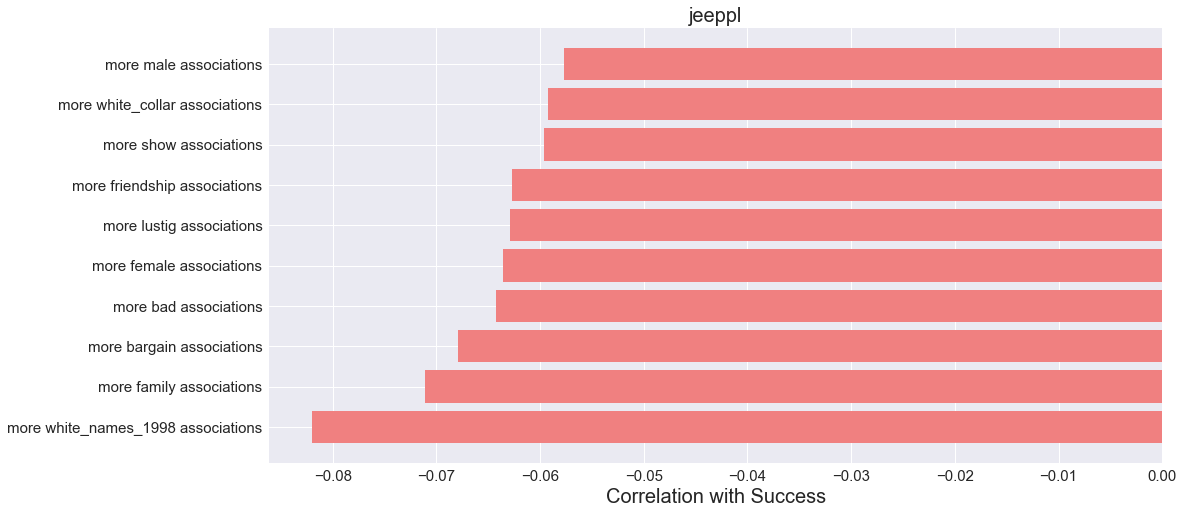

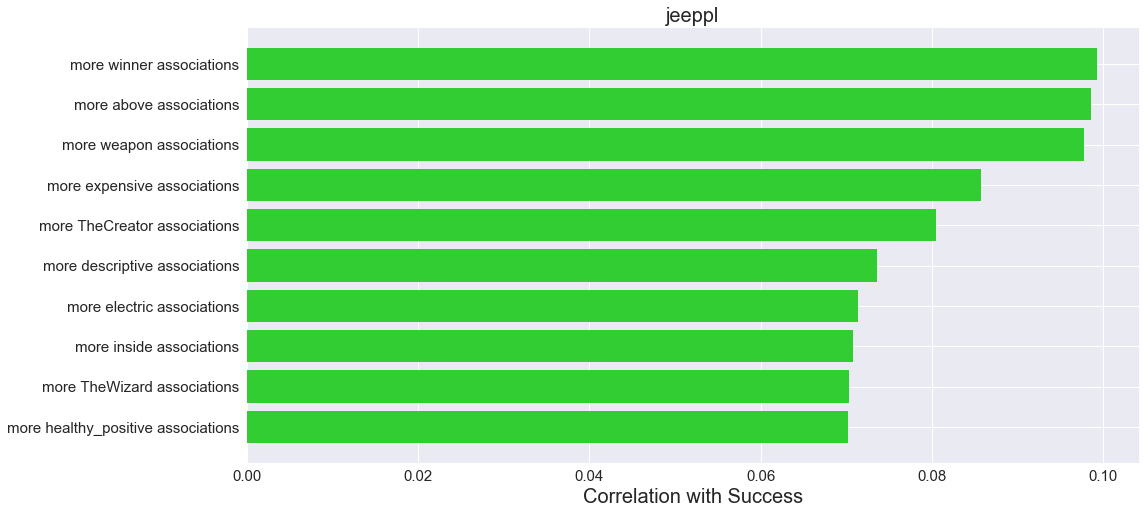

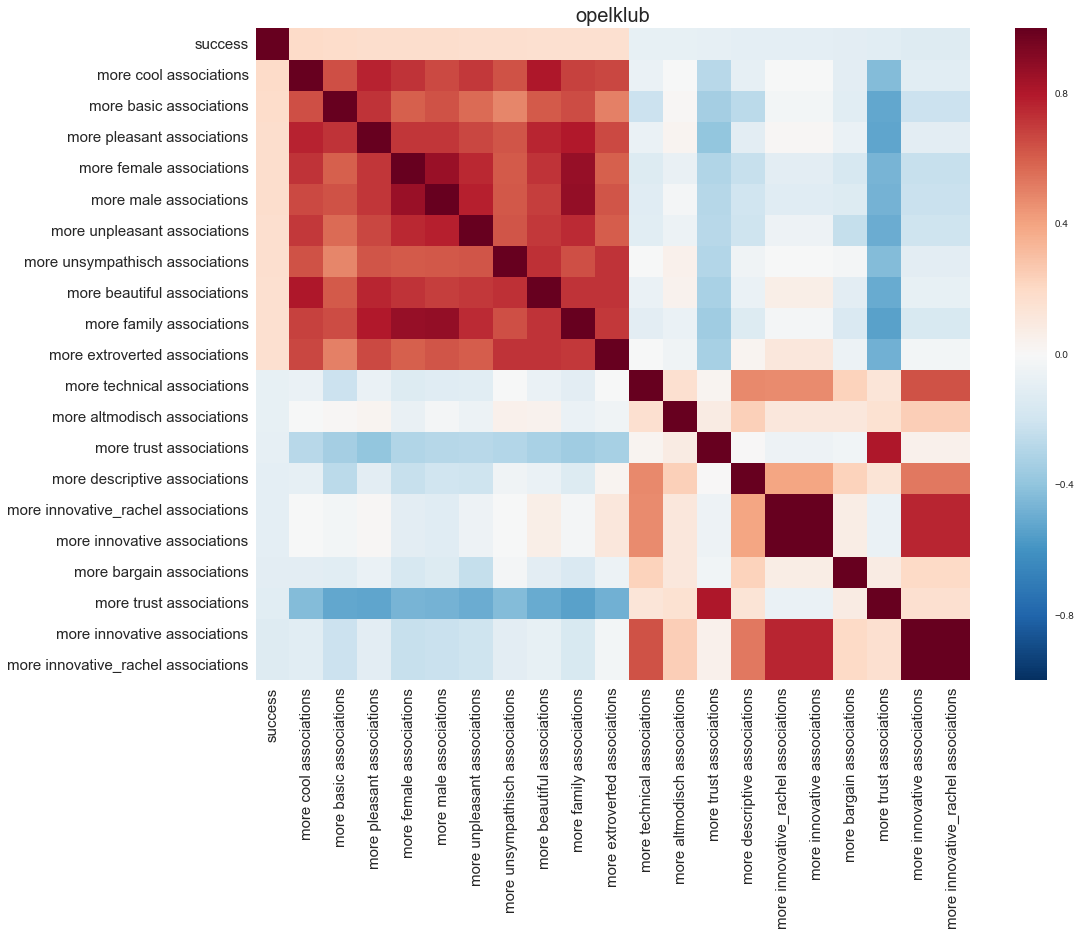

In [15]:
for file, filename in zip(files, filenames):
    try:
        print("doing {}".format(filename))
        pl = preprocess_csv(file)
        feats = get_similarity_features(pl, dimensions)
        get_top_bot(feats, filename)
    except:
        print("error encountered in {}".format(filename))
        continue

In [44]:
bmw = preprocess_csv('separated_pl/bmw.polska.csv')

/Users/piocalderon/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [47]:
bmw.iloc[337].Actual

'Profilaktyczne znieczulanie ""Blue Monday"" (http://pl.wikipedia.org/wiki/Blue_Monday) trwa - tym razem BMW X6 w pakiecie M Performance. Dla każdego coś miłego ;)'

In [40]:
feats

Post_text   success  \
0     [bmw, seria, grana, coupe, cieszyć, siebie, du...    42.625   
1     [blogo, nadal, poszukiwać, swoje, wymarzyć, bm...    15.375   
2     [dziękować, fan, który, zagłosować, wiek, odpo...    21.750   
3     [przekonać, siebie, jaka, wyglądać, fabryka, w...    27.000   
4     [rozpocząć, siebie, nowy, konkurs, wiek, gra, ...     2.125   
5     [jaka, siebie, podobać, pomysł, zimowy, wypraw...    33.125   
6     [blogo, wiek, koniec, kupić, swój, wymarzyć, b...    26.750   
7     [cza, tęsknić, za, prawdziwy, zima, taka, zoba...    12.375   
8     [zobaczyć, relacja, z, targi, motoryzacyjny, w...    41.875   
9     [zapraszać, lektura, najnowszy, wydanie, auto,...    11.000   
10    [pamiętać, największy, sukces, bmw, metr, z, u...    19.625   
11    [blogo, zastanawiać, siebie, nad, zakup, używa...     7.000   
12    [zaleta, bmw, seria, jaka, właściwość, jezdny,...    15.875   
13    [bmw, prezentować, nowy, wersja, model, bmw, x...    81.500   
14    [zbliżać, siebie, premier, rynkowy, nowy, bmw,...    66.250   
15    [ostatnio, zaprezentować, nowy, bmw, x, a, chc...    69.250   
16    [z, okazja, zbliżać, siebie, premiera, szósty,...   109.250   
17    [prezentować, szósty, generacja, bmw, seria, k...    31.750   
18    [przypominać, ojciec, trwać, konkurs, bmw, xdr...     2.250   
19    [oto, nowy, bmw, metr, dostępny, wiek, wersja,...   364.750   
20    [z, przyjemność, informować, iż, wiek, koniec,...    47.250   
21    [prezentować, wideo, przedstawiać, nowy, bmw, ...    56.250   
22    [mieć, zadać, specjalny, fan, bmw, móc, pochwa...    20.250   
23    [przypominać, ojciec, trwać, konkurs, najlepsz...    13.500   
24    [bezpieczeństwo, oda, istotny, aspekt, marka, ...    62.000   
25    [zapraszać, wziąć, udział, wiek, trwać, konkur...    10.000   
26    [bmw, prezentować, model, koncepcyjny, bmw, i,...    56.000   
27    [wiek, kolejny, konkurs, bmw, xdrive, challang...     4.750   
28    [narta, zostać, wysłać, zwycięzca, konkurs, bm...     7.750   
29                [fan, profil, bmw, polska, dziękować]    28.000   
...                                                 ...       ...   
2059  [oda, trwać, u, dealer, dzień, otwarty, oraz, ...    23.000   
2060  [deszcz, błoto, śnieg, cieszyć, siebie, chwila...    12.250   
2061  [doświadczyć, bmw, jaka, dotąd, podczas, nocny...     4.125   
2062  [klimat, tor, wyścigowy, nowy, bmw, seria, wyp...    43.750   
2063  [wygląd, dźwięk, mokry, oda, deszcz, hungarori...   242.250   
2064  [nowoczesny, stylistyk, bmw, seria, grana, tur...    93.625   
2065  [deszcz, błoto, śnieg, cieszyć, siebie, chwila...    13.625   
2066  [bmw, metr, cs, fenomenalny, stylistyk, ekscyt...    50.000   
2067  [nowy, bmw, x, z, przód, diodowy, reflektor, a...    50.375   
2068  [bmw, jazz, club, nowy, pokolenie, zapraszać, ...     4.875   
2069  [doświadczyć, bmw, jaka, dotąd, podczas, nocny...    11.000   
2070  [jeszcze, lepszy, osiąg, jeszcze, charakter, i...    69.750   
2071  [deszcz, śnieg, błoto, dzięki, bmw, xdrive, pe...    32.125   
2072  [taka, siebie, myśleć, z, okazja, blackfriday,...   160.000   
2073  [bmw, metr, z, akcesorium, metr, performance, ...    66.000   
2074  [bmw, i, roadster, trwać, ostatni, faza, testo...     8.250   
2075  [poznać, nowy, bmw, metr, cs, i, moc, karbonow...    56.625   
2076           [nowy, bmw, metr, klasa, biznes, prostu]    52.625   
2077  [kompletny, koło, zimowy, bmw, bezpieczeństwo,...    10.000   
2078  [alpina, były, vide, strona, kilometr, nm, kil...    70.625   
2079  [doposażyć, wiek, adrenalina, akcesorium, metr...    29.875   
2080  [deszcz, błoto, śnieg, cieszyć, siebie, chwila...    33.125   
2081  [nowy, bmw, x, jasny, określić, misja, bezwaru...    25.750   
2082  [bmw, seria, grana, turismo, zapewnić, wsparci...    33.875   
2083  [charakterystyczny, stylistyk, nowy, bmw, x, n...    34.625   
2084  [oto, bmw, metr, motogp, safety, car, zadebiut...    73.750   
2085  [nowy, bmw, metr, cs, auto, ojciec, be

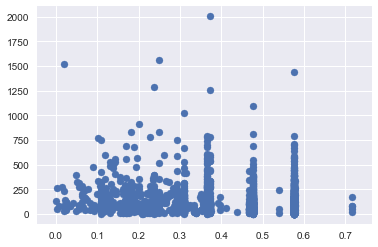

In [48]:
plt.scatter(feats['peak_pos_inside'], feats['success'])

In [28]:
feats.corr()['success'].sort_values(ascending=False)

success                         1.000000
count_pos_african_names         0.160556
count_pos_african_names_2004    0.145251
count_pos_musical_instrument    0.141353
mean_pos_lustig                 0.126257
count_pos_volkswagen            0.123388
count_pos_altmodisch            0.120091
count_pos_european_names        0.117838
count_pos_music                 0.115979
mean_pos_ugly                   0.107907
mean_pos_unsympathisch          0.106619
count_pos_trust                 0.096606
count_pos_basic                 0.096316
mean_pos_impractical            0.091767
mean_pos_cheap                  0.086413
count_pos_male                  0.084067
mean_pos_pleasant_2             0.080647
mean_pos_indulgent              0.079219
mean_pos_pleasant               0.079150
count_pos_traditionell          0.076415
mean_pos_TheJester              0.074900
count_pos_below                 0.074624
count_pos_white_names_1998      0.073978
mean_pos_TheInnocent            0.073111
count_pos_natürl

In [16]:
files[2]

'separated_pl/bmw.polska.csv'

# Inter-Brand Comparisons

In [17]:
corr_files = ['data/brands/' + x for x in os.listdir('data/brands') if x.endswith('.csv') and x.startswith('unlabel')]
corr_filenames = [x[x.find('/')+34: x.find('.csv')] for x in corr_files]

In [89]:
def plot_wordclouds(i, thres):
    data = pd.read_csv(corr_files[i], index_col='Unnamed: 0')
    top = data.columns[2:12]
    bottom = data.columns[12:]
    
    plt.figure(figsize=(15,10))

    top_words = [x.split()[1] for x in data.index[data['success']>thres][1:]] 
    bot_words = [x.split()[1] for x in data.index[data['success']<-thres][1:]]

    plt.subplot(121)
    plt.axis("off");
    if len(top_words) != 0:
        print(' '.join(top_words))
        wordcloud = WordCloud(width=600, height=500, background_color='white', prefer_horizontal=1, relative_scaling=0, min_font_size=70, max_font_size=70, stopwords = []).generate('healthy untrustworthy unwirksam impractical dead above below ugly bad cruel')
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title('Positively Correlated\n{} (>{})\n'.format(corr_filenames[i], str(thres)), size=25, )

    plt.subplot(122)
    plt.axis('off')
    if len(bot_words) != 0:
        wordcloud = WordCloud(width=600, height=500, background_color='white', prefer_horizontal=1, relative_scaling=0, min_font_size=70, max_font_size=70, stopwords = []).generate(' '.join([x.split()[1] for x in data.index[data['success']<-thres][1:]]))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title('Negatively Correlated \n{} (<-{})\n'.format(corr_filenames[i], str(thres)), size=25, )

    plt.savefig('fig/brands/wordclouds_{}.png'.format(corr_filenames[i]), bbox_inches = 'tight')
    plt.clf()

In [27]:
i=10
thres=.1

(-0.5, 999.5, 599.5, -0.5)

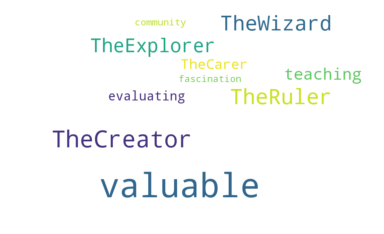

In [166]:
wordcloud = WordCloud(width=1000, height=600, background_color='white', prefer_horizontal=1).generate_from_frequencies(freqs, max_font_size=100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

valuable TheCreator TheRuler TheWizard TheExplorer teaching TheCarer evaluating community fascination
255.0
93.30242318013856
70.92589198342492
65.73754088802089
55.40608257863128
32.80284204467402
19.41720919130066
16.913650533123445
0.14581183233722664
0.0
european_names trust african_names
255.0
32.51550187119706
0.0


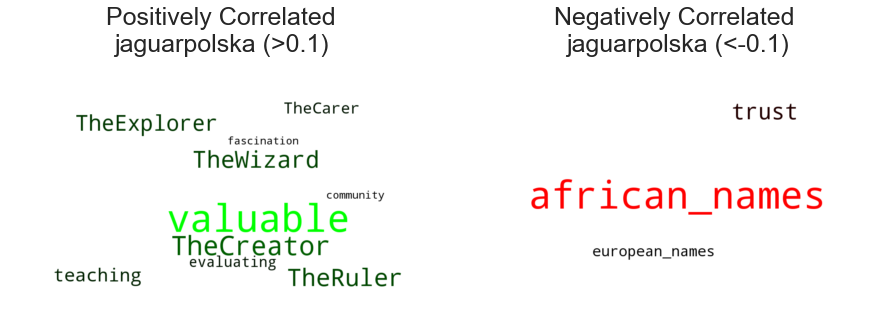

In [234]:
data = pd.read_csv(corr_files[i], index_col='Unnamed: 0')
top = data.columns[2:12]
bottom = data.columns[12:]

plt.figure(figsize=(15,10))

top_words = [x.split()[1] for x in data.index[data['success']>thres][1:]] 
bot_words = [x.split()[1] for x in data.index[data['success']<-thres][1:]]

top_corr = data.loc[data['success']>thres,'success'][1:].values
bot_corr = -data.loc[data['success']<-thres,'success'][1:].values

# scale correlations to 1:20
top_corr = 19*(top_corr-min(top_corr))/(max(top_corr)-min(top_corr))+1
bot_corr = 19*(bot_corr-min(bot_corr))/(max(bot_corr)-min(bot_corr))+1

top_freqs = dict(zip(top_words, top_corr))
bot_freqs = dict(zip(bot_words, bot_corr))

plt.subplot(121)
plt.axis("off");
if len(top_words) != 0:
    print(' '.join(top_words))
    wordcloud = WordCloud(width=1000, height=600, background_color='white', prefer_horizontal=1, color_func=my_tf_color_func(top_freqs, 'G')).generate_from_frequencies(top_freqs, max_font_size=100)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Positively Correlated\n{} (>{})\n'.format(corr_filenames[i], str(thres)), size=25, )

plt.subplot(122)
plt.axis('off')
if len(bot_words) != 0:
    print(' '.join(bot_words))
    wordcloud = WordCloud(width=1000, height=600, background_color='white', prefer_horizontal=1, color_func=my_tf_color_func(bot_freqs, 'R')).generate_from_frequencies(bot_freqs, max_font_size=100)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Negatively Correlated \n{} (<-{})\n'.format(corr_filenames[i], str(thres)), size=25, )


In [66]:
x = pd.read_csv('data/brands/correlogram_volkswagenpolska.csv')['success']

In [35]:
def my_tf_color_func(dictionary, color):
    maxval = max(dictionary.values())
    minval = min(dictionary.values())
    def my_tf_color_func_inner(word, font_size, position, orientation, random_state=None, **kwargs):
        if len(dictionary) > 1:
            value = (dictionary[word] - minval) / (maxval - minval)
        else:
            value = 1
        if color == 'R':
            return "rgb({}, 0, 0)".format(int(value*255))
        elif color == 'G':
            return "rgb(0, {}, 0)".format(int(value*255))
    return my_tf_color_func_inner


In [45]:
def plot_wordclouds(i, count, thres, top_words, bot_words, top_corr, bot_corr, fig):

    ax1 = fig.add_subplot(19, 2, count)
    ax1.axis("off");
    if len(top_words) != 0:
        # scale correlations to 1:20
        if len(top_words) > 1:
            top_corr = 19*(top_corr-min(top_corr))/(max(top_corr)-min(top_corr))+1
        else:
            top_corr = [20]
        top_freqs = dict(zip(top_words, top_corr))
        
        wordcloud = WordCloud(width=1000, height=600, background_color='white', prefer_horizontal=1, color_func=my_tf_color_func(top_freqs, 'G')).generate_from_frequencies(top_freqs, max_font_size=100)
        ax1.imshow(wordcloud, interpolation='bilinear')
        ax1.set_title('\n{}\nPOS\n'.format(corr_filenames[i], str(thres)), size=42, fontweight='bold')

    ax2 = fig.add_subplot(19, 2, count+1)
    ax2.axis('off')
    if len(bot_words) != 0:
        # scale correlations to 1:20
        if len(bot_words) > 1:
            bot_corr = 19*(bot_corr-min(bot_corr))/(max(bot_corr)-min(bot_corr))+1
        else:
            bot_corr = [20]
        bot_freqs = dict(zip(bot_words, bot_corr))
        
        wordcloud = WordCloud(width=1000, height=600, background_color='white', prefer_horizontal=1, color_func=my_tf_color_func(bot_freqs, 'R')).generate_from_frequencies(bot_freqs, max_font_size=100)
        ax2.imshow(wordcloud, interpolation='bilinear')
        ax2.set_title('\n{}\nNEG\n'.format(corr_filenames[i], str(thres)), size=42, fontweight='bold')

#     plt.savefig('fig/brands/wordclouds_{}.png'.format(corr_filenames[i]), bbox_inches = 'tight')

volkswagenpolska
lexuspolska
jaguarpolska
['above', 'alive', 'big', 'blunt', 'career', 'children', 'closed', 'community', 'cool', 'cruel', 'culture', 'descriptive', 'design', 'destructive', 'innovative', 'responsible', 'TheRebel', 'appetitlich', 'emotionally_stable', 'ernst', 'evaluating', 'expensive', 'extraverted', 'extrovert', 'extroverted', 'family', 'fascination', 'healthy_positive', 'healthy_restrictive', 'indulgent', 'cold', 'inside', 'introverted', 'kind', 'kompliziert', 'lazy', 'lifestyle', 'male', 'nachhaltig', 'natürlich', 'neurotic', 'diligent', 'outside', 'pleasant', 'bargain', 'power', 'practical', 'protective', 'small', 'sustainable', 'sustainable', 'attractive', 'teaching', 'TheCarer', 'TheCitizen', 'TheCreator', 'TheExplorer', 'TheHero', 'TheInnocent', 'TheJester', 'open', 'traditional', 'TheRuler', 'TheSage', 'TheWizard', 'trustworthy', 'unappetitlich', 'unattractive', 'uncool', 'unkompliziert', 'unnatürlich', 'unsustainable', 'unsustainable', 'untrustworthy', 'unwirk

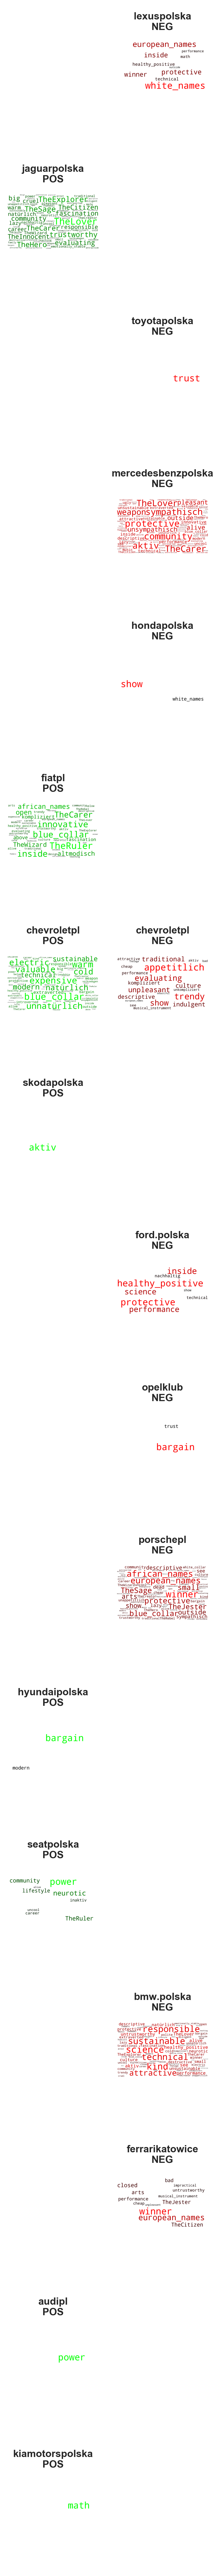

In [47]:
fig = plt.figure(figsize=(15,220))

thres = .1
for cat in ['peak']:
    count = 1
    for i in range(len(corr_filenames)):
        print(corr_filenames[i])
        data = pd.read_csv(corr_files[i], index_col='Unnamed: 0')
        
        to_retain = [x for x in data.columns if cat in x or x=='success']
        data = data.loc[to_retain, to_retain]

        data.index = [get_label(re.sub(r'_[0-9]+', '', x)) for x in data.index]
        data.columns = [get_label(re.sub(r'_[0-9]+', '', x)) for x in data.columns]
        top_words = [x.split()[1] for x in data.index[data['success']>thres][1:]] 
        bot_words = [x.split()[1] for x in data.index[data['success']<-thres][1:]]

        top_words = [x for x in top_words if x != 'innovative_rachel']
        bot_words = [x for x in bot_words if x != 'innovative_rachel']

        if (len(top_words) != 0) or (len(bot_words) != 0):
            top_corr = data.loc[data['success']>thres,'success'][1:].values
            bot_corr = -data.loc[data['success']<-thres,'success'][1:].values
            plot_wordclouds(i, count, .1, top_words, bot_words, top_corr, bot_corr, fig)
            count += 2
    plt.savefig('fig/brands/wordclouds_ALL_{}.png'.format(cat), bbox_inches = 'tight')


In [72]:
pl = preprocess_csv(files[-5])
feats = get_similarity_features(pl, dimensions)
#get_top_bot(feats, filenames[-5])


/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [63]:
peugeot = pd.read_csv('data/brands/unlabeled_all_correlogram_peugeotpolska.csv')

In [67]:
peugeot.set_index(peugeot.columns[0])['success'].sort_values(ascending=False)

Unnamed: 0
success                          1.000000
mean_pos_healthy_positive        0.124374
count_pos_untrustworthy          0.120556
count_pos_unwirksam              0.115205
count_pos_impractical            0.110151
count_pos_dead                   0.109112
count_pos_above                  0.108630
count_pos_below                  0.108237
count_pos_ugly                   0.106597
count_pos_bad                    0.103108
count_pos_cruel                  0.101563
count_pos_introverted            0.101079
count_pos_traditionell           0.100996
count_pos_TheCitizen             0.097350
count_pos_big                    0.093086
count_pos_closed                 0.091337
count_pos_valuable               0.089957
count_pos_lustig                 0.089645
count_pos_healthy_restrictive    0.088382
count_pos_TheInnocent            0.088181
count_pos_sympathisch            0.087910
count_pos_uncool                 0.085386
count_pos_destructive            0.084655
count_pos_math         

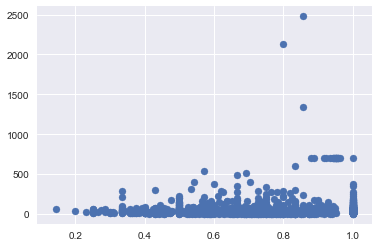

In [69]:
plt.scatter(feats['count_pos_untrustworthy'], feats['success'])

In [75]:
feats[feats['count_pos_untrustworthy'] == 1].Actual.iloc[0]

'Przedstawiamy zdjęcia Nowego Partnera i Experta'